In [2]:
#all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OneHotEncoder
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from collections import defaultdict

from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI

best_k = 3 #change for different case


Text_Numeracy = "In a few sentences, please describe an experience in your life that demonstrated your knowledge of health or medical issues."
Text_Anxiety = "In a few sentences, please describe what makes you feel most anxious or worried when visiting the doctor's office."
Text_TrustPhys = "In a few sentences, please explain the reasons why you trust or distrust your primary care physician. If you do not have a primary care physician, please answer in regard to doctors in general."
Text_SubjectiveLit = "Regarding all the questions you just answered, to what degree do you feel you have the capacity to obtain, process, and understand basic health information and services needed to make appropriate health decisions? Please explain your answer in a few sentences."

## Table for demographic/behavioral/psychological features

In [2]:
# 文件路径
file_path = 'Data\Data_SurveyPlusDemographics.txt'

# 读取文件
data = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1')

data = data.dropna()

# Display the remaining number of rows after dropping missing values
remaining_rows = data.shape[0]
print(f'Remaining number of rows after dropping missing values: {remaining_rows}')

# 显示数据的前几行
print(data.head())

Remaining number of rows after dropping missing values: 8120
   File  Row   Q1   Q2   Q3  Q4  FQ1  FQ2  FQ3  ComQ1  ...   D6  Dmed_7  \
0     1    1  5.0  5.0  4.0   5  3.0  1.0    3    1.0  ...  1.0    30.0   
1     1    2  4.0  4.0  4.0   4  3.0  1.0    3    2.0  ...  1.0    29.0   
2     1    3  5.0  5.0  4.0   4  3.0  1.0    3    1.0  ...  1.0    32.0   
3     1    4  5.0  5.0  4.0   4  3.0  4.0    3    1.0  ...  1.0    31.0   
4     1    5  5.0  5.0  5.0   5  3.0  1.0    3    1.0  ...  1.0    34.0   

   Dmed_8 DMed_1  DMed_2  DMed_3  DMed_9  Dmed_10  Dmed_5  Dmed_6  
0     152    4.0     1.0     4.0     3.0      5.0     1.0     1.0  
1     150    3.0     1.0     8.0     3.0      6.0     1.0     1.0  
2     160    1.0     1.0     4.0     6.0      5.0     1.0     1.0  
3     168    5.0     1.0    12.0     2.0      5.0     1.0     3.0  
4     220    5.0     1.0    12.0     3.0      4.0     7.0    15.0  

[5 rows x 123 columns]


C:\Users\howar\AppData\Local\Temp\ipykernel_23784\533319393.py:5: DtypeWarning: Columns (115) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1')


In [3]:


# 定义数值到自然语言的映射
def map_values_to_text(column, value):
    mappings = {
        'ATQ': {
            1: "never",
            2: "rarely",
            3: "sometimes",
            4: "often",
            5: "always"
        },
        'TWB': {
            1: "strongly disagree",
            2: "disagree",
            3: "neutral",
            4: "agree",
            5: "strongly agree"
        },
        'RA1': {
            1: "very unlikely",
            2: "unlikely",
            3: "likely",
            4: "very likely",
            5: "extremely likely"
        },
        'STAI': {
            1: "never",
            2: "rarely",
            3: "sometimes",
            4: "often",
            5: "always"
        },
        'BSCS': {
            1: "strongly disagree",
            2: "disagree",
            3: "neutral",
            4: "agree",
            5: "strongly agree"
        },
        'REI': {
            1: "strongly disagree",
            2: "disagree",
            3: "neutral",
            4: "agree",
            5: "strongly agree"
        },
        'FIPI': {
            1: "strongly disagree",
            2: "disagree",
            3: "neutral",
            4: "agree",
            5: "strongly agree"
        }
    }
    prefix = column.split('_')[0]
    return mappings[prefix].get(value, "unknown")

# 为每类问题定义一个关键词
keywords = {
    'ATQ': "negative thoughts",
    'TWB': "well-being",
    'RA1': "risk activities",
    'STAI': "feelings",
    'BSCS': "self-control",
    'REI': "thinking style",
    'FIPI_1': "extraverted and enthusiastic",
    'FIPI_2': "agreeable and kind",
    'FIPI_3': "dependable and organized",
    'FIPI_4': "emotionally stable and calm",
    'FIPI_5': "open to experience and imaginative"
}

# 计算每个大主题下的小问题的众数
def calculate_mode(data):
    modes = {}
    for prefix in set(key.split('_')[0] for key in keywords.keys()):
        relevant_columns = [col for col in data.columns if col.startswith(prefix)]
        if relevant_columns:
            modes[prefix] = data[relevant_columns].mode(axis=1)[0]
    return modes

# 将数值数据转换为自然语言描述并存储在单独的列中
def convert_to_natural_language(data):
    new_columns = []
    modes = calculate_mode(data)
    for prefix, mode_values in modes.items():
        responses = []
        for index in range(len(data)):
            text = map_values_to_text(prefix, mode_values.iloc[index])
            keyword = keywords.get(prefix) or keywords.get(f"{prefix}_{index + 1}")
            # 生成自然语言描述
            if 'ATQ' in prefix:
                responses.append(f"Over the last week, I have had {keyword} {text}.")
            elif 'TWB' in prefix:
                responses.append(f"I {text} that my {keyword} is good.")
            elif 'RA1' in prefix:
                responses.append(f"I am {text} to engage in {keyword}.")
            elif 'STAI' in prefix:
                responses.append(f"I feel {keyword} {text}.")
            elif 'BSCS' in prefix:
                responses.append(f"I {text} that my {keyword} is strong.")
            elif 'REI' in prefix:
                responses.append(f"I {text} with my {keyword}.")
            elif 'FIPI' in prefix:
                responses.append(f"I {text} that I am {keyword}.")
        col_name = f'{prefix}_response'
        data[col_name] = responses
        new_columns.append(col_name)
    return data, new_columns

# 将FIPI部分拆分成5个单独的列
def split_fipi_responses(data):
    fipi_columns = []
    for i in range(1, 6):
        responses = []
        prefix = f'FIPI_{i}'
        for index in range(len(data)):
            text = map_values_to_text(prefix, data[f'FIPI_{i}'].iloc[index])
            keyword = keywords[prefix]
            responses.append(f"I {text} that I am {keyword}.")
        col_name = f'FIPI_{i}_response'
        data[col_name] = responses
        fipi_columns.append(col_name)
    return data, fipi_columns

# 转换数据
data, psychological_list = convert_to_natural_language(data)
data, fipi_columns = split_fipi_responses(data)

# 删除合并后的FIPI_response列
data.drop(columns=['FIPI_response'], inplace=True, errors='ignore')

# 合并新列名称列表
psychological_list.extend(fipi_columns)

# 打印包含自然语言描述的DataFrame
print(data)

# 打印新列名称列表
print("New column names:", psychological_list)


      File   Row   Q1   Q2   Q3  Q4  FQ1  FQ2  FQ3  ComQ1  ...  \
0        1     1  5.0  5.0  4.0   5  3.0  1.0    3    1.0  ...   
1        1     2  4.0  4.0  4.0   4  3.0  1.0    3    2.0  ...   
2        1     3  5.0  5.0  4.0   4  3.0  1.0    3    1.0  ...   
3        1     4  5.0  5.0  4.0   4  3.0  4.0    3    1.0  ...   
4        1     5  5.0  5.0  5.0   5  3.0  1.0    3    1.0  ...   
...    ...   ...  ...  ...  ...  ..  ...  ...  ...    ...  ...   
8497     5  1696  5.0  5.0  5.0   5  3.0  4.0    3    1.0  ...   
8498     5  1697  5.0  5.0  5.0   5  3.0  1.0    3    1.0  ...   
8499     5  1698  5.0  5.0  5.0   5  3.0  4.0    3    1.0  ...   
8500     5  1699  3.0  2.0  4.0   2  1.0  1.0    3    1.0  ...   
8501     5  1700  5.0  5.0  5.0   5  3.0  4.0    3    1.0  ...   

                                         BSCS_response  \
0              I agree that my self-control is strong.   
1              I agree that my self-control is strong.   
2            I neutral that my se

In [21]:
demographic_list = [
    "D1",
    "D2",
    "D3",
    "D4",
    "D5"
]


behavioral_list  = [
    "HC_1",
    "HC_2",
    "HC_3",
    "HC_4",
    "HC_5"
]

psychological_list= ['FIPI_1_response',
 'FIPI_2_response',
 'FIPI_3_response',
 'FIPI_4_response',
 'FIPI_5_response']

text_label_list = [
    "Text_Numeracy",
    "Text_Anxiety",
    "Text_TrustPhys",
    "Text_SubjectiveLit"
]

cat_label_list = [
    "Label_Numeracy",
    "Label_Anxiety",
    "Label_TrustPhys",
    "Label_SubjectiveLit",
    
]

demographic_data = data[demographic_list]
behavioral_data = data[behavioral_list]
psychological_data = data[psychological_list]

In [22]:
train_data = data[demographic_list + behavioral_list+ psychological_list]

In [23]:
import pandas as pd
import re


# 定义一个函数来清理数值数据
def clean_numeric(value):
    if isinstance(value, str):
        # 使用正则表达式提取数值部分
        numeric_value = re.findall(r'\d+', value)
        if numeric_value:
            return float(numeric_value[0])
        else:
            return None
    return value

# 清理数据，将所有列转换为数值类型
for column in demographic_data.columns:
    train_data[column] = train_data[column].apply(clean_numeric)

for column in behavioral_data.columns:
    train_data[column] = train_data[column].apply(clean_numeric)

# 获取第一行数据
first_row = train_data.iloc[0]

# 按列名、数据类型和内容分别打印
for column_name in train_data.columns:
    value = first_row[column_name]
    dtype = train_data[column_name].dtype
    print(f"{column_name} (Type: {dtype}): {value}")

# 检查清理后的数据
print(train_data.head())


D1 (Type: float64): 21.0
D2 (Type: float64): 2.0
D3 (Type: float64): 1.0
D4 (Type: float64): 6.0
D5 (Type: float64): 1.0
HC_1 (Type: float64): 5.0
HC_2 (Type: float64): 5.0
HC_3 (Type: float64): 5.0
HC_4 (Type: float64): 5.0
HC_5 (Type: float64): 4.0
FIPI_1_response (Type: object): I disagree that I am extraverted and enthusiastic.
FIPI_2_response (Type: object): I strongly agree that I am agreeable and kind.
FIPI_3_response (Type: object): I strongly agree that I am dependable and organized.
FIPI_4_response (Type: object): I unknown that I am emotionally stable and calm.
FIPI_5_response (Type: object): I unknown that I am open to experience and imaginative.
     D1   D2   D3   D4   D5  HC_1  HC_2  HC_3  HC_4  HC_5  \
0  21.0  2.0  1.0  6.0  1.0   5.0   5.0   5.0   5.0   4.0   
1  22.0  2.0  1.0  4.0  3.0   5.0   5.0   5.0   5.0   5.0   
2  33.0  2.0  1.0  6.0  6.0   4.0   4.0   4.0   4.0   4.0   
3  17.0  2.0  1.0  5.0  6.0   4.0   4.0   5.0   4.0   3.0   
4  17.0  1.0  1.0  4.0  1.0 

C:\Users\howar\AppData\Local\Temp\ipykernel_23784\4292403929.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = train_data[column].apply(clean_numeric)
C:\Users\howar\AppData\Local\Temp\ipykernel_23784\4292403929.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = train_data[column].apply(clean_numeric)


## Categorize into subgroups

In [25]:
#demo
bins = [0, 13, 43,70]
labels = ['18-29', '30-59', '60 and above']
train_data['D1'] = pd.cut(train_data['D1'], bins=bins, labels=labels, right=False)

# Define bins and labels for D4 based on education levels
bins_d4 = [0, 3, 9]  # Split at 3 because 2 and 3 are lower education, while 4-7 are higher education, and 8 goes into lower
labels_d4 = ['Education lower than college', 'Education higher than college']

# Apply binning to D4 column
train_data['D4'] = pd.cut(train_data['D4'], bins=bins_d4, labels=labels_d4, right=False)

# Map income values to low and high income categories
train_data['D5'] = train_data['D5'].apply(lambda x: 'Low Income' if x in [1, 2, 3] else ('High Income' if x in [4, 5, 6] else 'Other'))

# Optional: If you want to include 'Do not know / not sure' and 'I choose not to answer' in 'Other'
train_data['D5'] = train_data['D5'].apply(lambda x: 'Other' if x in [7, 8] else x)


C:\Users\howar\AppData\Local\Temp\ipykernel_23784\3463470786.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['D1'] = pd.cut(train_data['D1'], bins=bins, labels=labels, right=False)
C:\Users\howar\AppData\Local\Temp\ipykernel_23784\3463470786.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['D4'] = pd.cut(train_data['D4'], bins=bins_d4, labels=labels_d4, right=False)
C:\Users\howar\AppData\Local\Temp\ipykernel_23784\3463470786.py:14: SettingWithCopyWarning: 
A value is trying to

In [26]:
#behavioral
def convert_to_categorical(df):
    # 转换健康意识相关问题
    health_statements = ['HC_1', 'HC_2', 'HC_3', 'HC_4', 'HC_5']
    for col in health_statements:
        df[f'{col}'] = pd.cut(df[col], bins=[0, 2, 4, 5], labels=['Disagree', 'Neutral', 'Agree'])

    return df


train_data = convert_to_categorical(train_data)

C:\Users\howar\AppData\Local\Temp\ipykernel_23784\1027370943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}'] = pd.cut(df[col], bins=[0, 2, 4, 5], labels=['Disagree', 'Neutral', 'Agree'])
C:\Users\howar\AppData\Local\Temp\ipykernel_23784\1027370943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}'] = pd.cut(df[col], bins=[0, 2, 4, 5], labels=['Disagree', 'Neutral', 'Agree'])
C:\Users\howar\AppData\Local\Temp\ipykernel_23784\1027370943.py:6: SettingWithCopyWarning: 
A value is t

In [28]:
train_data

,D1,D2,D3,D4,D5,HC_1,HC_2,HC_3,HC_4,HC_5,FIPI_1_response,FIPI_2_response,FIPI_3_response,FIPI_4_response,FIPI_5_response
0,30-59,2.0,1.0,Education higher than college,Low Income,Agree,Agree,Agree,Agree,Neutral,I disagree that I am extraverted and enthusias...,I strongly agree that I am agreeable and kind.,I strongly agree that I am dependable and orga...,I unknown that I am emotionally stable and calm.,I unknown that I am open to experience and ima...
1,30-59,2.0,1.0,Education higher than college,Low Income,Agree,Agree,Agree,Agree,Agree,I unknown that I am extraverted and enthusiastic.,I unknown that I am agreeable and kind.,I unknown that I am dependable and organized.,I strongly agree that I am emotionally stable ...,I agree that I am open to experience and imagi...
2,30-59,2.0,1.0,Education higher than college,High Income,Neutral,Neutral,Neutral,Neutral,Neutral,I strongly agree that I am extraverted and ent...,I unknown that I am agreeable and kind.,I unknown that I am dependable and organized.,I unknown that I am emotionally stable and calm.,I unknown that I am open to experience and ima...
3,30-59,2.0,1.0,Education higher than college,High Income,Neutral,Neutral,Agree,Neutral,Neutral,I disagree that I am extraverted and enthusias...,I unknown that I am agreeable and kind.,I unknown that I am dependable and organized.,I agree that I am emotionally stable and calm.,I unknown that I am open to experience and ima...
4,30-59,1.0,1.0,Education higher than college,Low Income,Agree,Agree,Agree,Agree,Neutral,I disagree that I am extraverted and enthusias...,I unknown that I am agreeable and kind.,I unknown that I am dependable and organized.,I agree that I am emotionally stable and calm.,I unknown that I am open to experience and ima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,30-59,2.0,2.0,Education higher than college,Low Income,Agree,Agree,Agree,Agree,Neutral,I unknown that I am extraverted and enthusiastic.,I unknown that I am agreeable and kind.,I unknown that I am dependable and organized.,I strongly agree that I am emotionally stable ...,I unknown that I am open to experience and ima...
8498,18-29,2.0,2.0,Education higher than college,Low Income,Agree,Agree,Agree,Agree,Agree,I unknown that I am extraverted and enthusiastic.,I unknown that I am agreeable and kind.,I unknown that I am dependable and organized.,I unknown that I am emotionally stable and calm.,I unknown that I am open to experience and ima...
8499,60 and above,1.0,1.0,Education higher than college,High Income,Agree,Agree,Agree,Agree,Agree,I unknown that I am extraverted and enthusiastic.,I unknown that I am agreeable and kind.,I unknown that I am dependable and organized.,I unknown that I am emotionally stable and calm.,I agree that I am open to experience and imagi...
8500,30-59,2.0,2.0,Education higher than college,Low Income,Disagree,Disagree,Agree,Disagree,Disagree,I strongly agree that I am extraverted and ent...,I unknown that I am agreeable and kind.,I strongly disagree that I am dependable and o...,I unknown that I am emotionally stable and calm.,I neutral that I am open to experience and ima...


In [29]:
# Ensure all features are treated as categorical
train_data = train_data.astype('category')

c:\Users\howar\Anaconda3\envs\gpt\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


For n_clusters = 3, the average silhouette score is: 0.4701
For n_clusters = 4, the average silhouette score is: 0.4423
For n_clusters = 5, the average silhouette score is: 0.4564
For n_clusters = 6, the average silhouette score is: 0.3726
For n_clusters = 7, the average silhouette score is: 0.3636
For n_clusters = 8, the average silhouette score is: 0.3808
For n_clusters = 9, the average silhouette score is: 0.4044
For n_clusters = 10, the average silhouette score is: 0.3938
For n_clusters = 11, the average silhouette score is: 0.3917
For n_clusters = 12, the average silhouette score is: 0.3885
For n_clusters = 13, the average silhouette score is: 0.3704
For n_clusters = 14, the average silhouette score is: 0.3799
For n_clusters = 15, the average silhouette score is: 0.3928


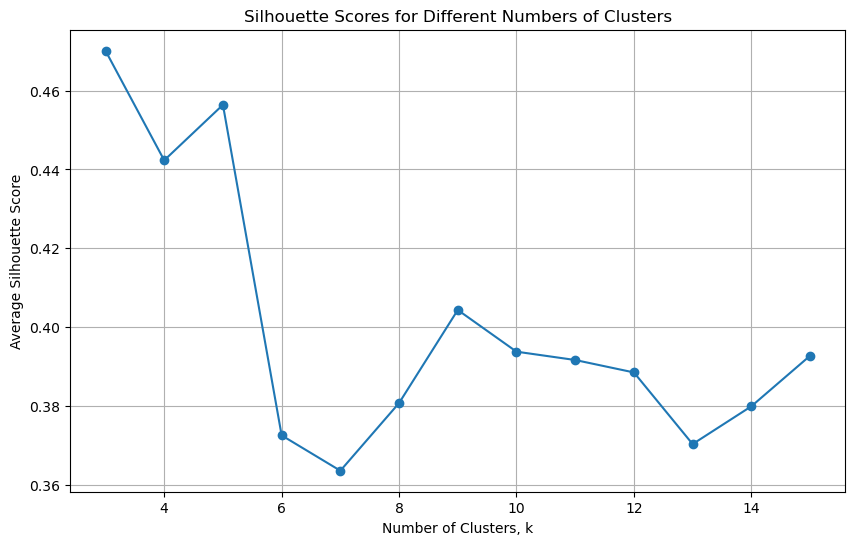

In [31]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming 'train_data' is your DataFrame containing the categorical data

# One-hot encode all categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(train_data)
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(train_data.columns))

# Standardize the encoded features
scaler = StandardScaler()
scaled_encoded_categorical_df = scaler.fit_transform(encoded_categorical_df)

# Apply UMAP for dimensionality reduction
umap = UMAP(n_components=3, n_neighbors=30, min_dist=0.3, random_state=42)
reduced_data = umap.fit_transform(scaled_encoded_categorical_df)

def test_k_values(reduced_data, max_k):
    silhouette_scores = []
    k_values = range(3, max_k + 1)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(reduced_data)
        silhouette_avg = silhouette_score(reduced_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f'For n_clusters = {k}, the average silhouette score is: {silhouette_avg:.4f}')
    return k_values, silhouette_scores

# Test k values from 2 to 15
k_values, silhouette_scores = test_k_values(reduced_data, 15)

import matplotlib.pyplot as plt

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.grid(True)
plt.show()




c:\Users\howar\Anaconda3\envs\gpt\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score for K-means with k=3: 0.3948


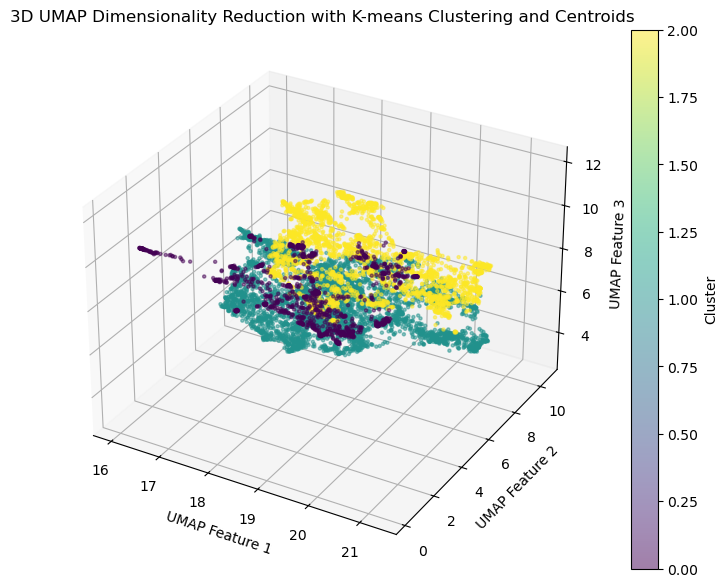

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder
from umap import UMAP
import pandas as pd

# 假设 train_data 是你的DataFrame，包含所有要编码的类别特征
categorical_columns = train_data.columns.tolist()

# One-hot encode all categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(train_data[categorical_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns))

# Apply UMAP for 3D dimensionality reduction
umap = UMAP(n_components=3, random_state=42)
reduced_data = umap.fit_transform(encoded_categorical_df)

# 假设 reduced_data 是已经降维处理的数据
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_data)
centroids = kmeans.cluster_centers_

# 添加聚类标签到原始数据
train_data['clusters'] = cluster_labels
data['clusters'] = cluster_labels

# 计算并打印轮廓系数
silhouette_avg = silhouette_score(reduced_data, cluster_labels)
print(f'Silhouette Score for K-means with k={best_k}: {silhouette_avg:.4f}')

# 绘制3D UMAP结果、聚类标签和质心
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 绘制数据点
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=cluster_labels, cmap='viridis', s=5, alpha=0.5)
# 绘制质心
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=50, marker='x')  # 以红色'x'标记质心

ax.set_title('3D UMAP Dimensionality Reduction with K-means Clustering and Centroids')
ax.set_xlabel('UMAP Feature 1')
ax.set_ylabel('UMAP Feature 2')
ax.set_zlabel('UMAP Feature 3')
fig.colorbar(sc, label='Cluster')

plt.show()


In [14]:
data[train_data.columns] = train_data

# 分割数据集为7个子数据集
clustered_datasets = {}
for i in range(best_k):
    clustered_datasets[f'Cluster_{i}'] = data[data['clusters'] == i]

# 显示每个子数据集的前几行，验证分割的正确性
for cluster, dataset in clustered_datasets.items():
    print(f"Dataset for {cluster} (first 5 rows):")
    print(dataset.head())
    print("\n")

Dataset for Cluster_0 (first 5 rows):
    File  Row   Q1   Q2   Q3  Q4  FQ1  FQ2  FQ3  ComQ1  ...  \
3      1    4  5.0  5.0  4.0   4  3.0  4.0    3    1.0  ...   
6      1    7  3.0  5.0  4.0   2  2.0  2.0    2    2.0  ...   
7      1    8  3.0  4.0  4.0   4  3.0  2.0    3    2.0  ...   
10     1   11  4.0  4.0  3.0   5  3.0  1.0    3    1.0  ...   
11     1   12  5.0  2.0  2.0   4  3.0  2.0    3    1.0  ...   

                                         ATQ_response  \
3   Over the last week, I have had negative though...   
6   Over the last week, I have had negative though...   
7   Over the last week, I have had negative though...   
10  Over the last week, I have had negative though...   
11  Over the last week, I have had negative though...   

                 STAI_response                       REI_response  \
3       I feel feelings often.    I agree with my thinking style.   
6       I feel feelings never.  I neutral with my thinking style.   
7   I feel feelings sometimes.   

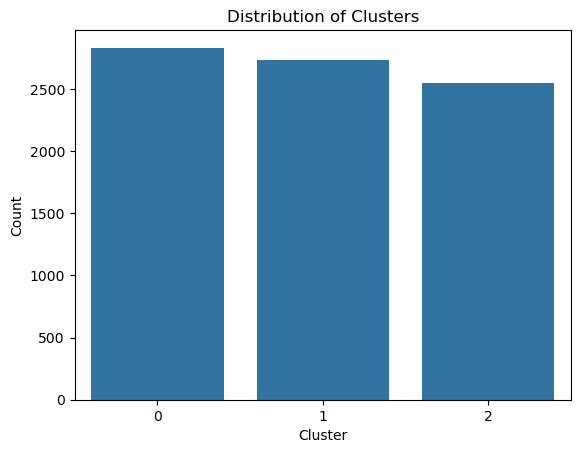

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制条形图
sns.countplot(x='clusters', data=data)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

## Significance Testing

             D1      D2     D3                D4                 D5   D6  \
clusters                                                                   
0         18-29  Female  White      Some college  Less than $20,000  Yes   
1         30-39    Male  White  College graduate  $35,000 - $54,999  Yes   
2         30-39  Female  White  College graduate  $35,000 - $54,999  Yes   

         Dmed_7       Dmed_8     DMed_1 DMed_2  ...  \
clusters                                        ...   
0             1  125-150 lbs  1 or less    Yes  ...   
1             2     >200 lbs  1 or less    Yes  ...   
2             1  125-150 lbs  1 or less    Yes  ...   

                                          TWB_response  \
clusters                                                 
0                  I agree that my well-being is good.   
1                  I agree that my well-being is good.   
2         I strongly agree that my well-being is good.   

                                               ATQ_r

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


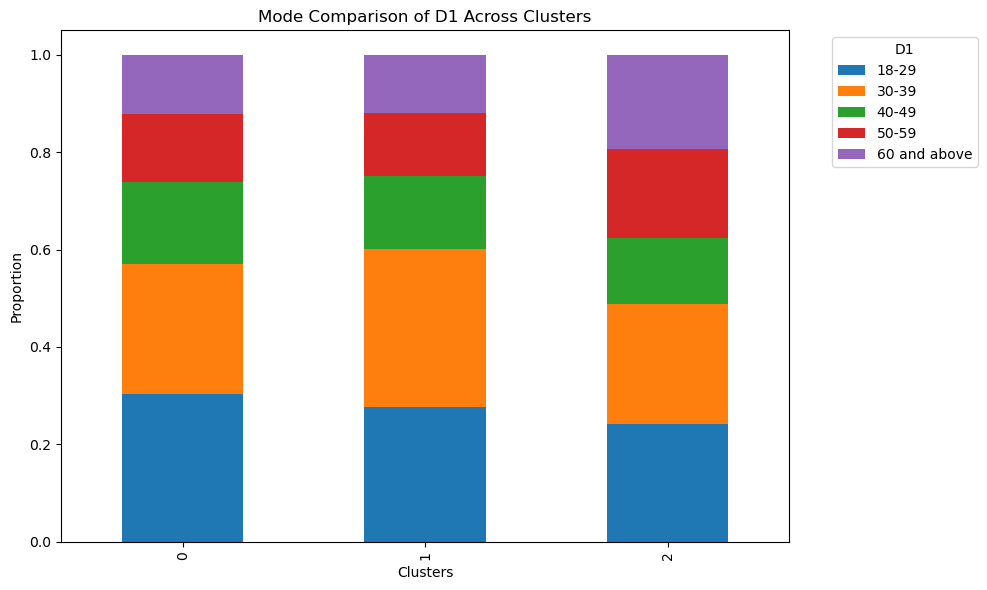

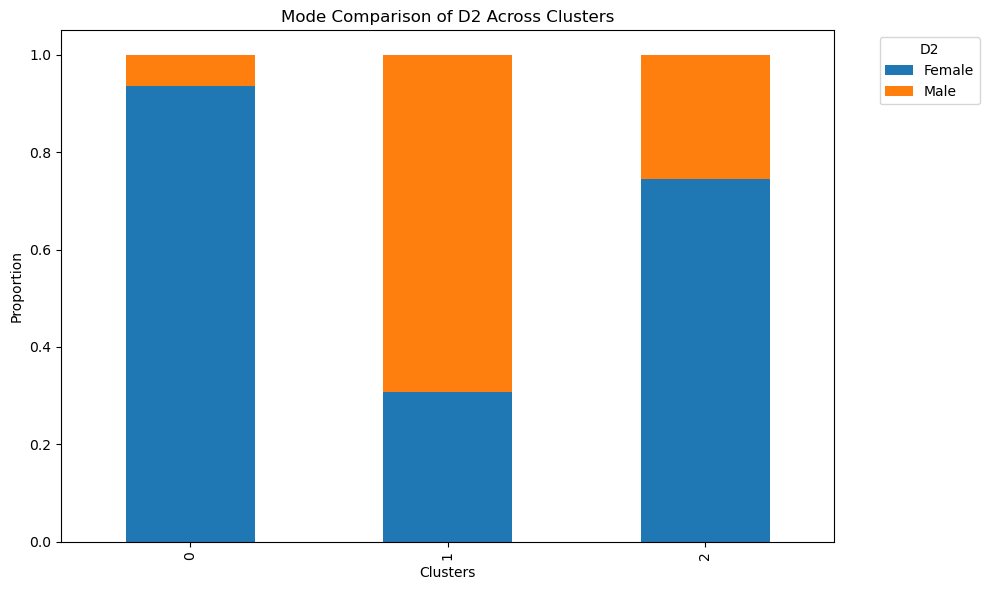

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


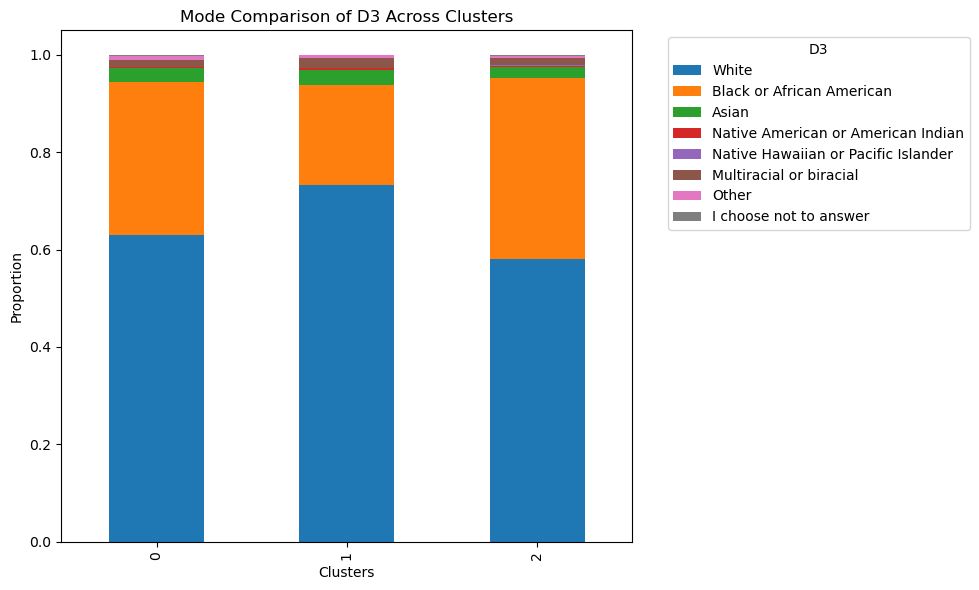

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


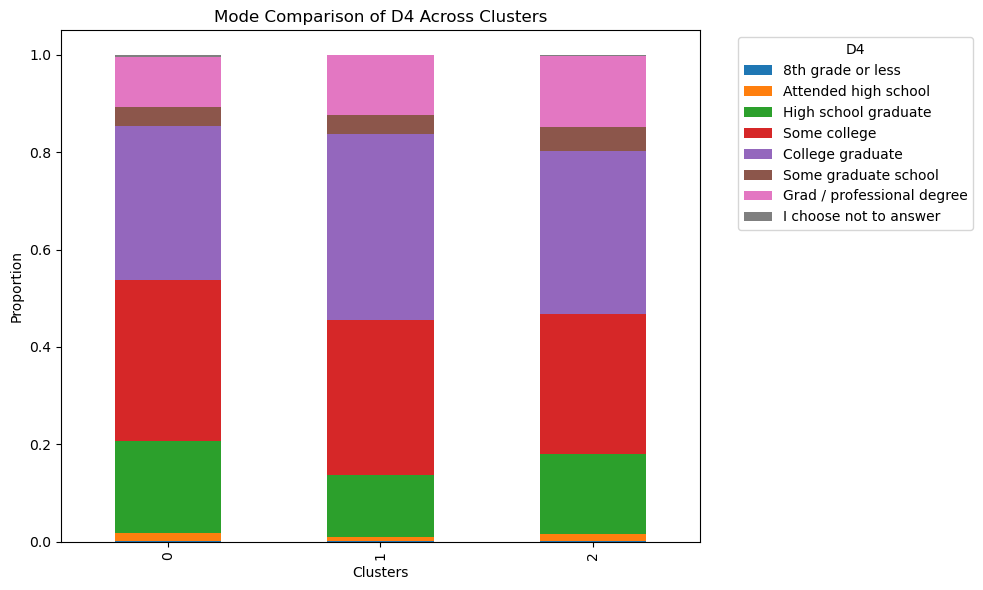

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


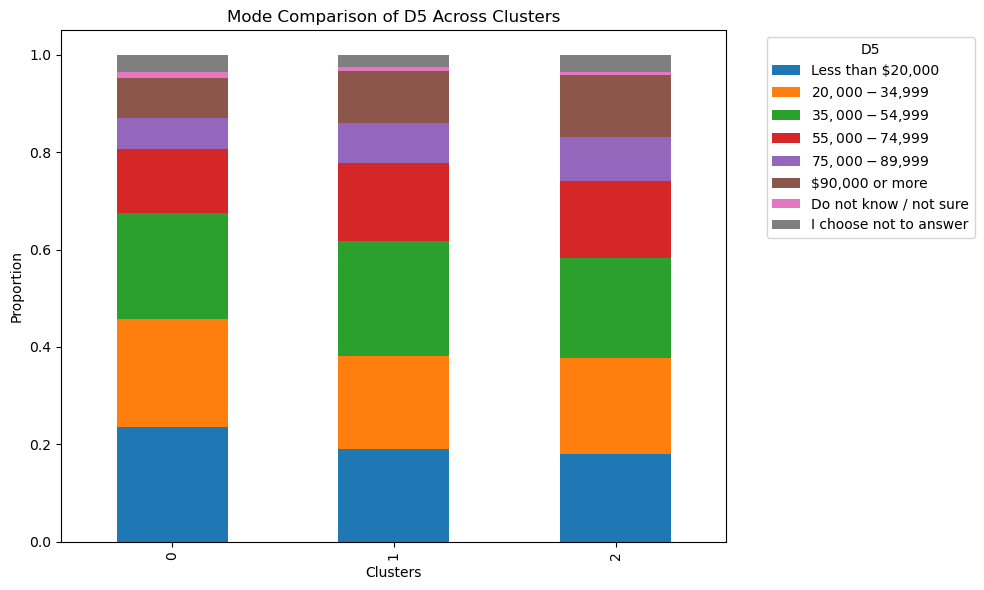

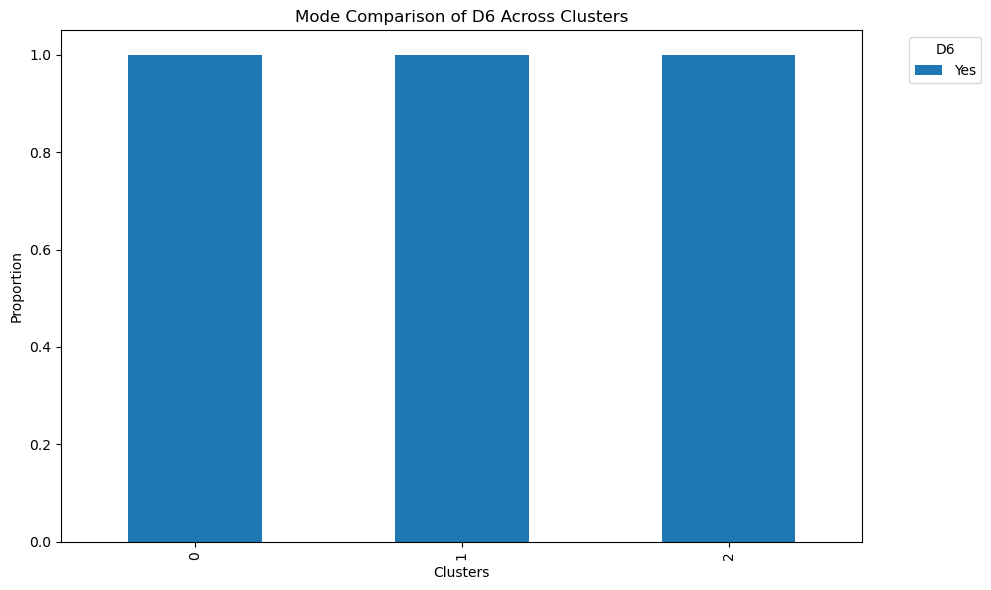

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


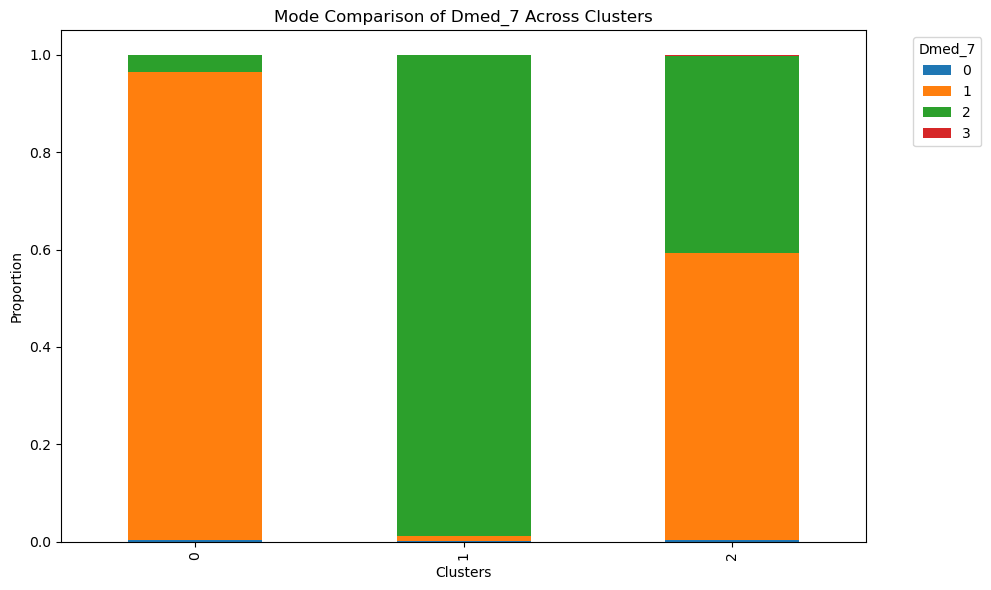

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


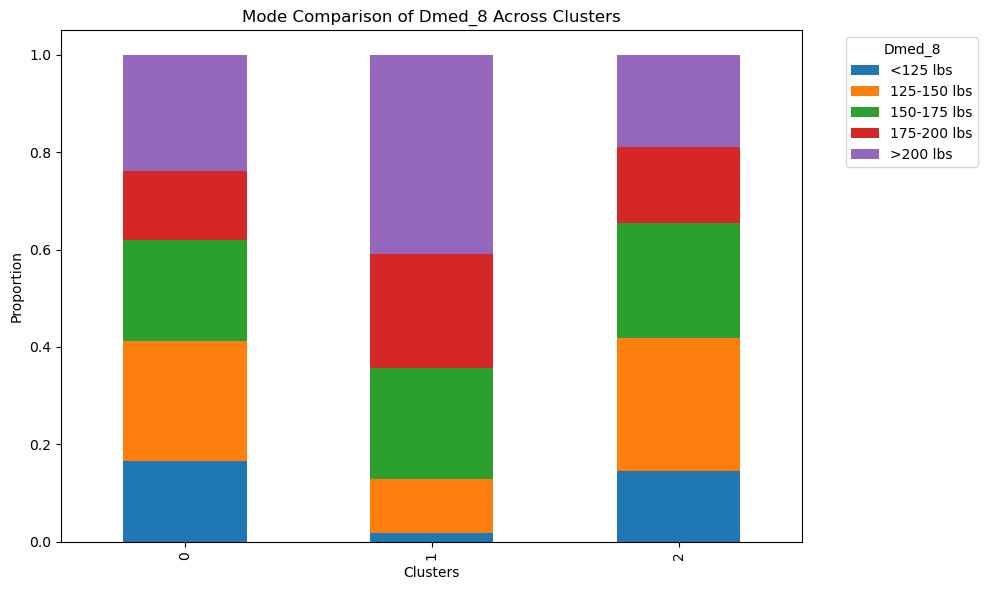

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


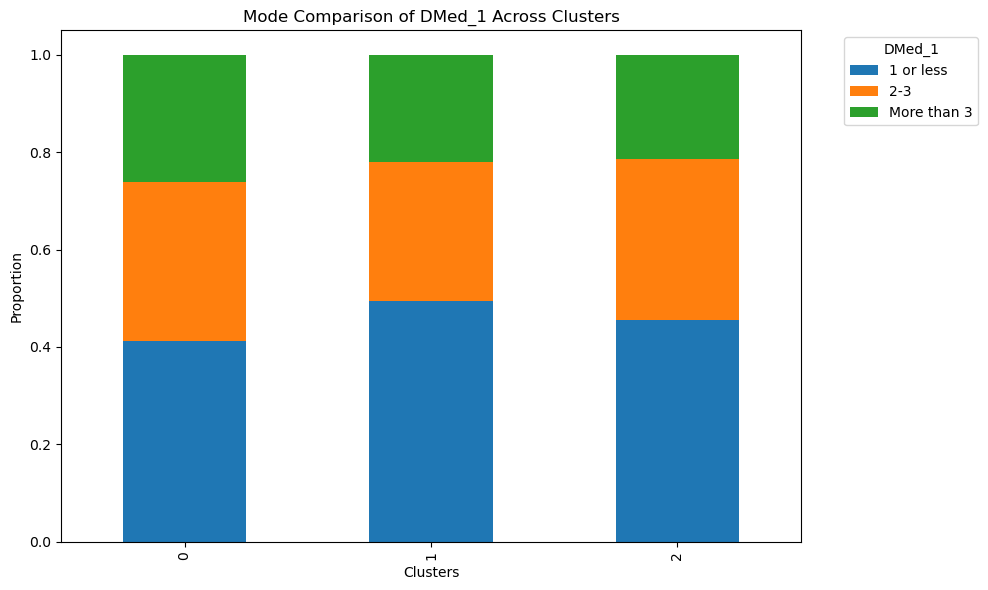

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


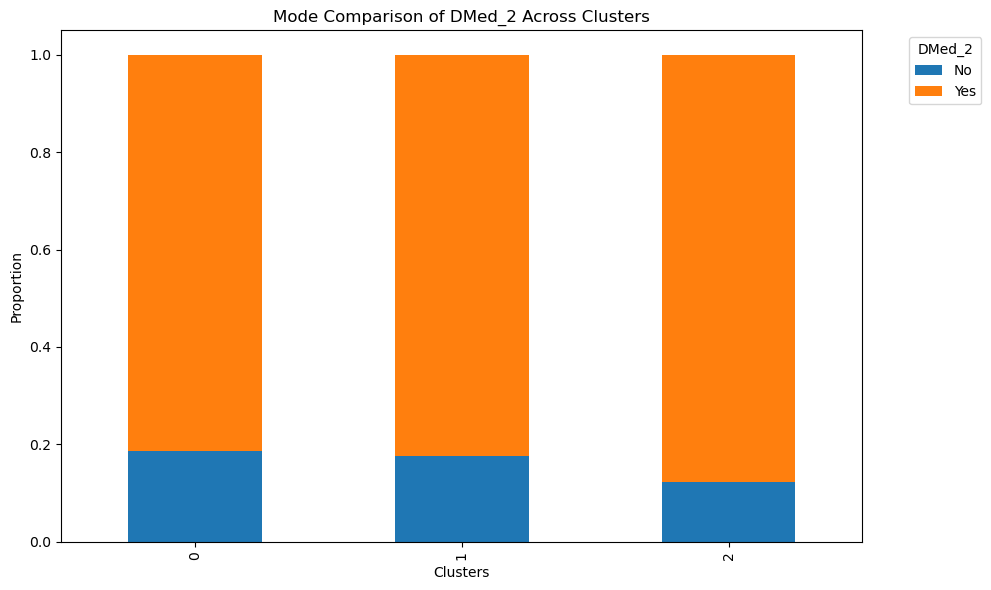

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


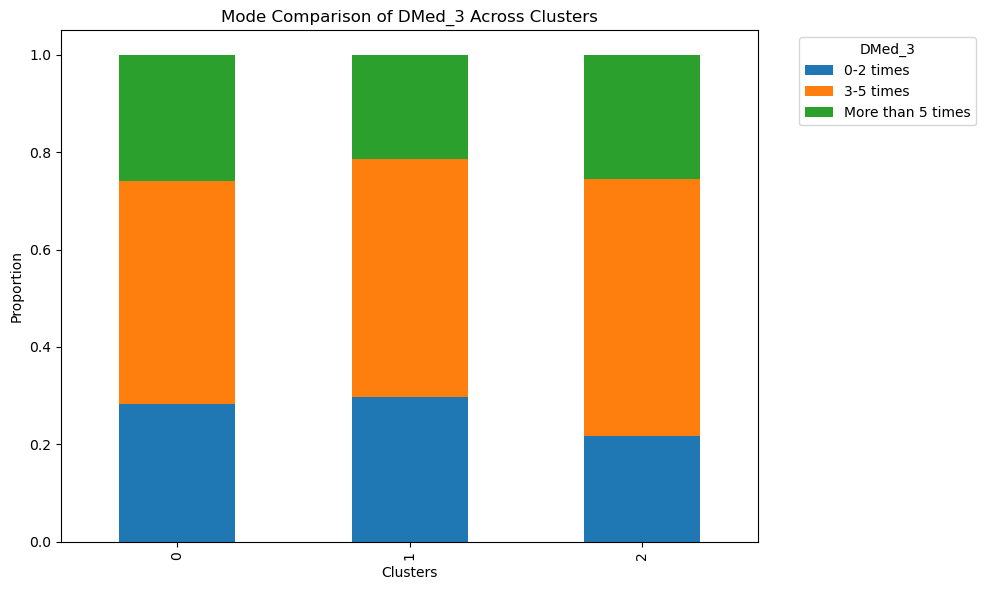

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


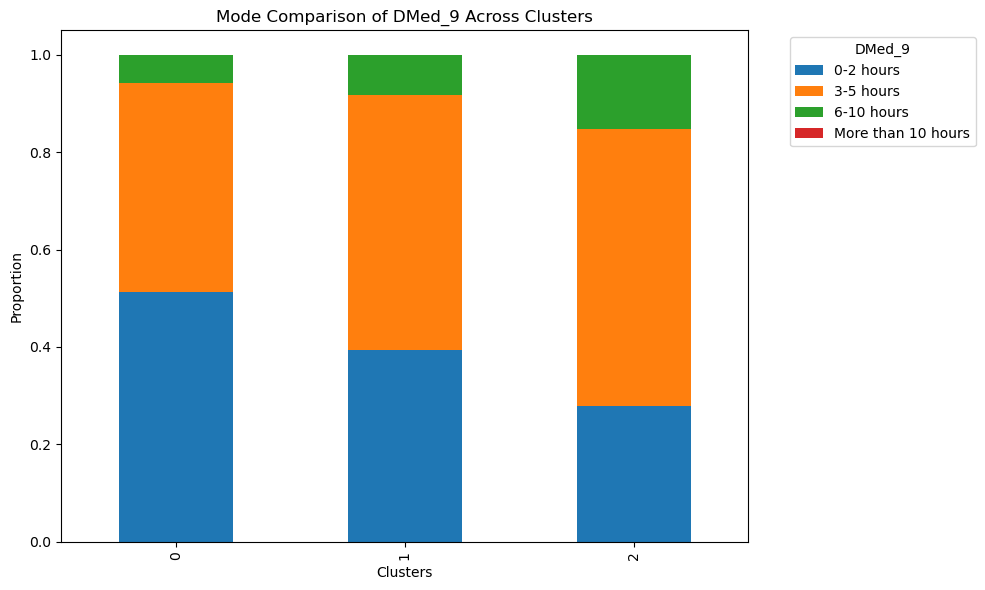

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


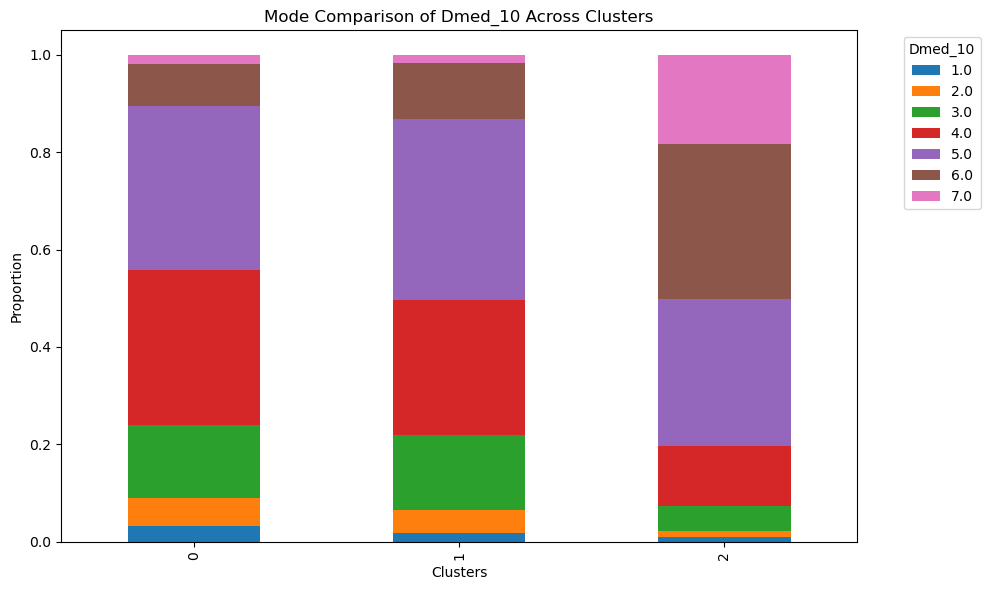

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


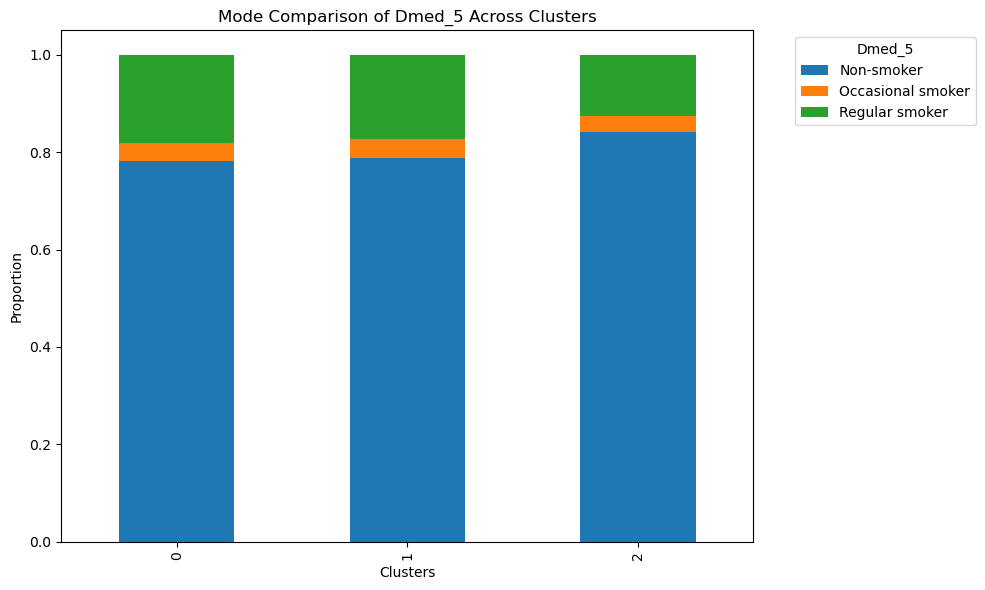

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


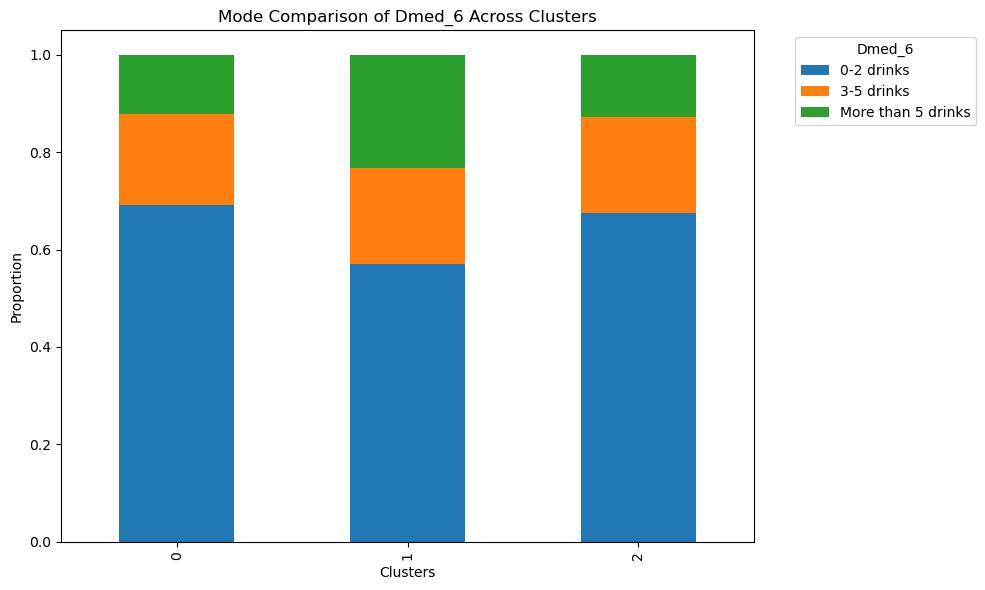

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


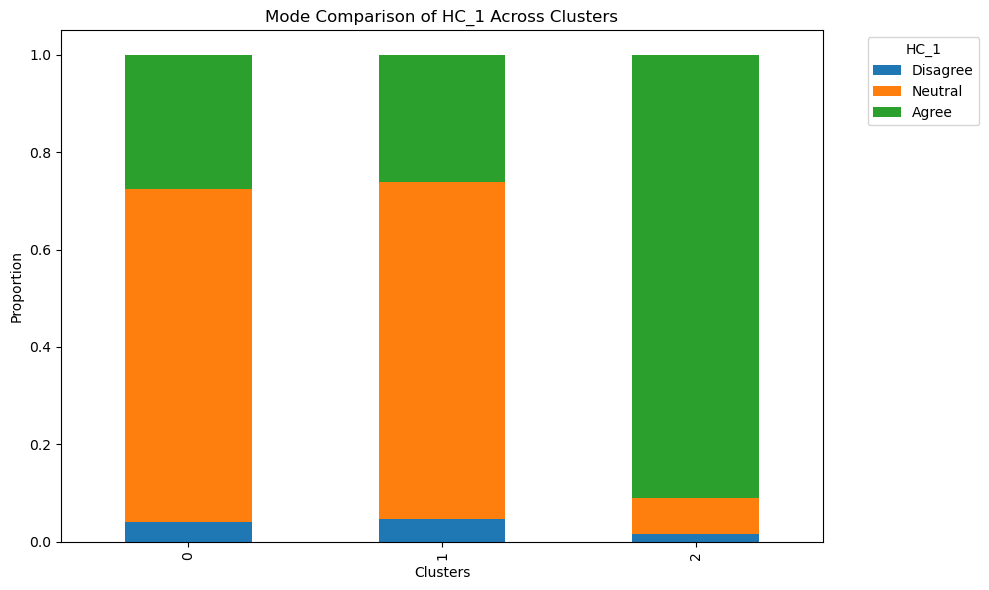

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


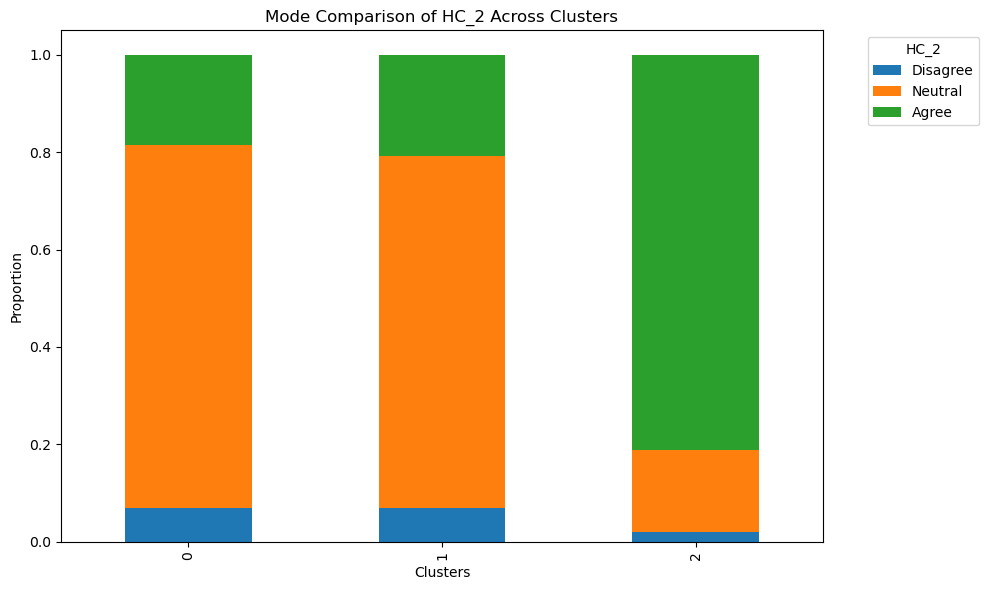

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


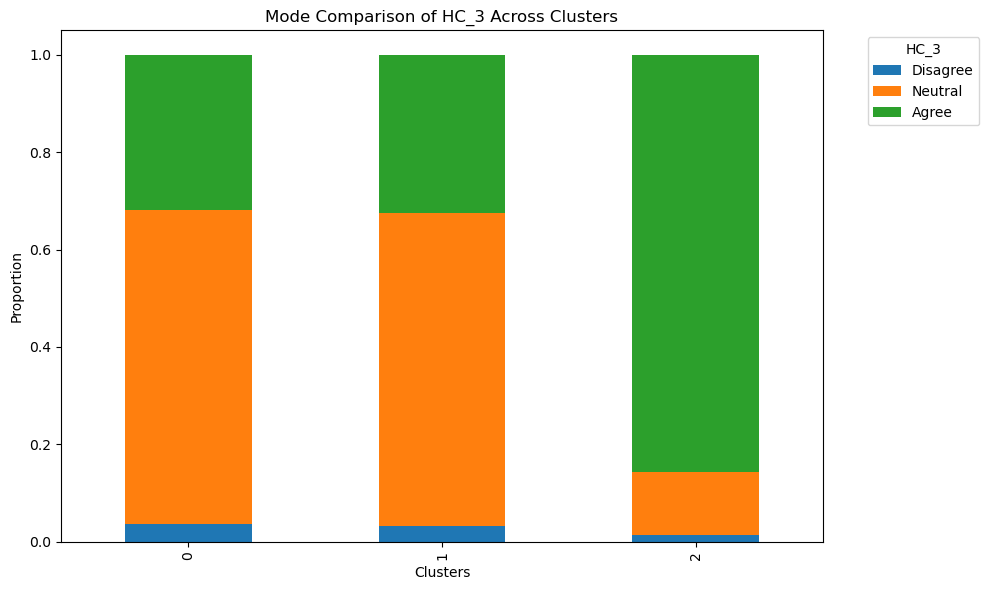

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


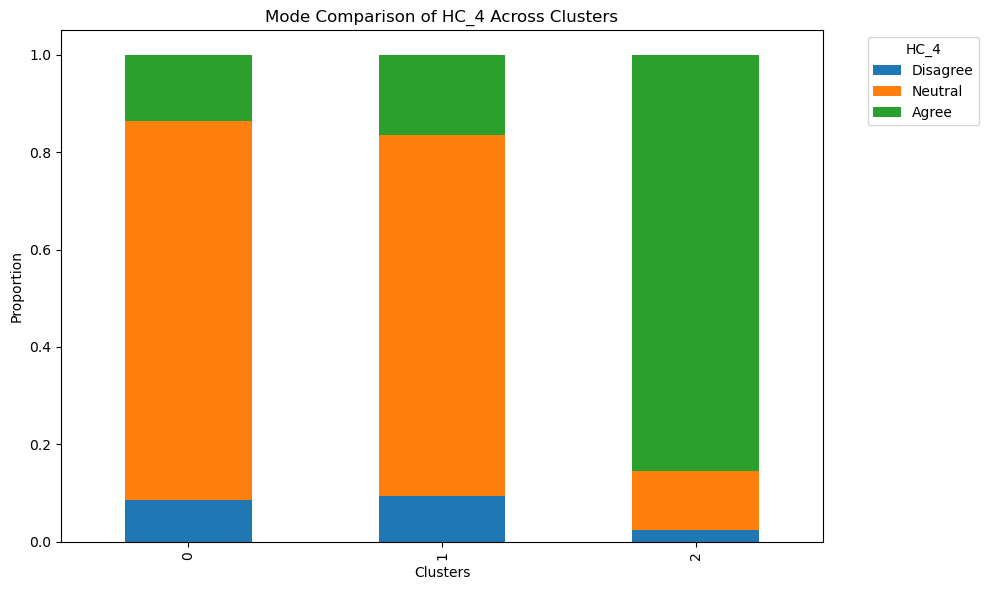

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


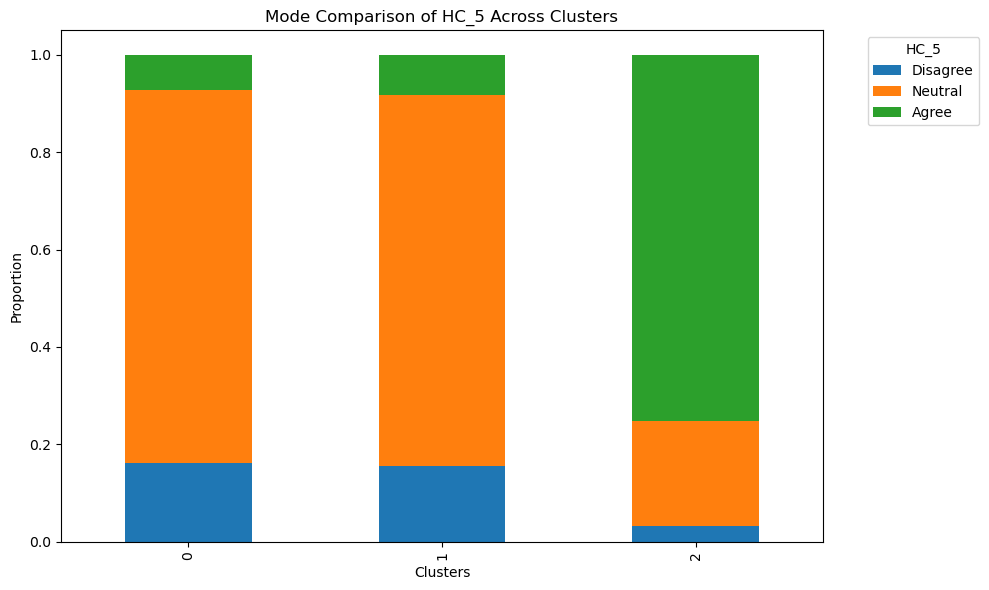

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


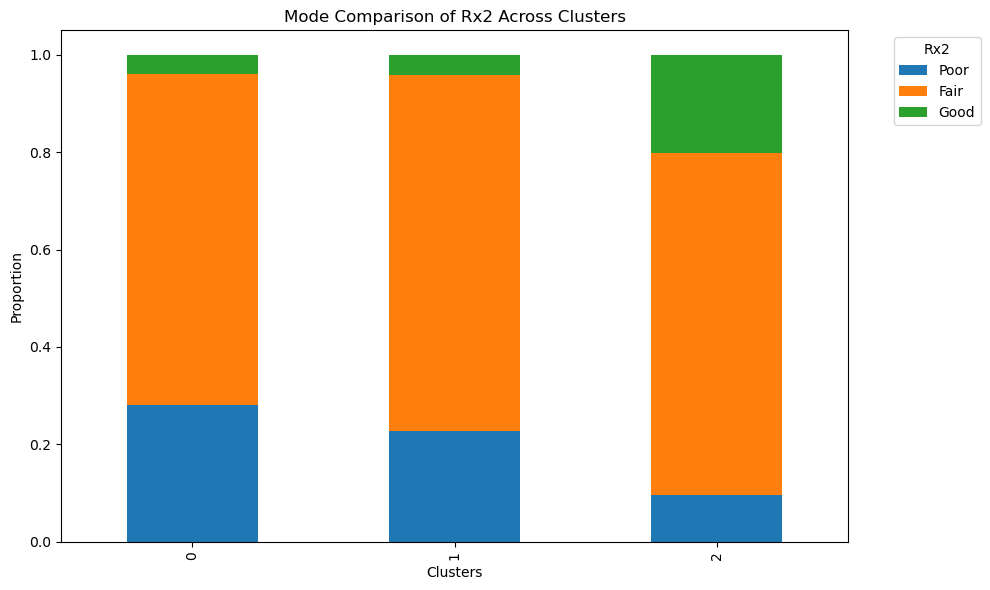

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


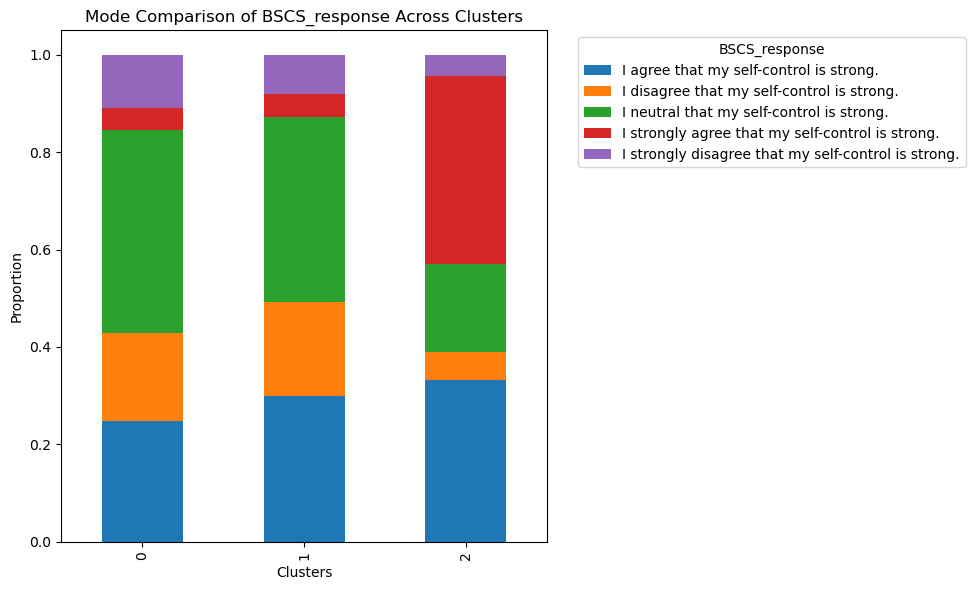

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


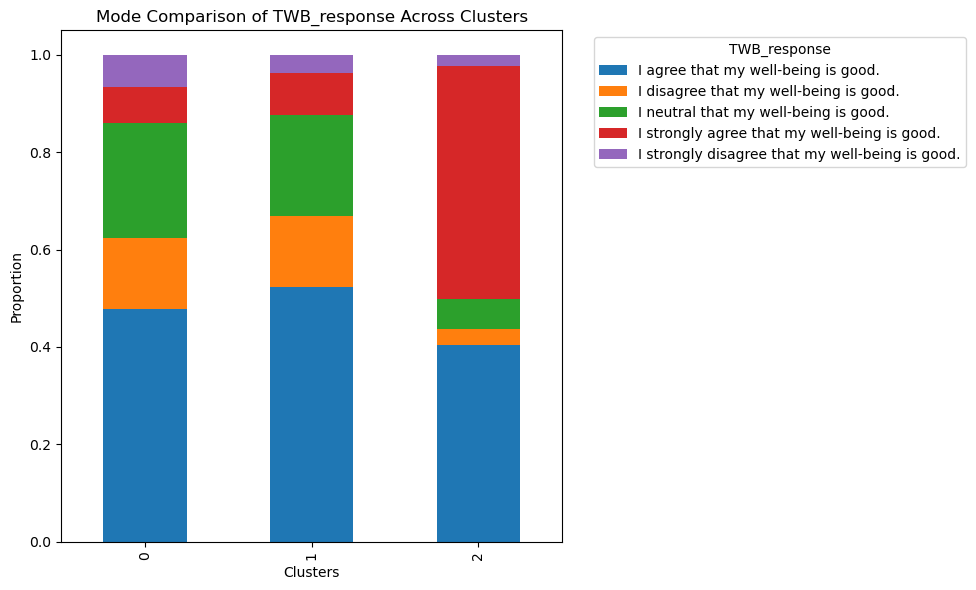

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


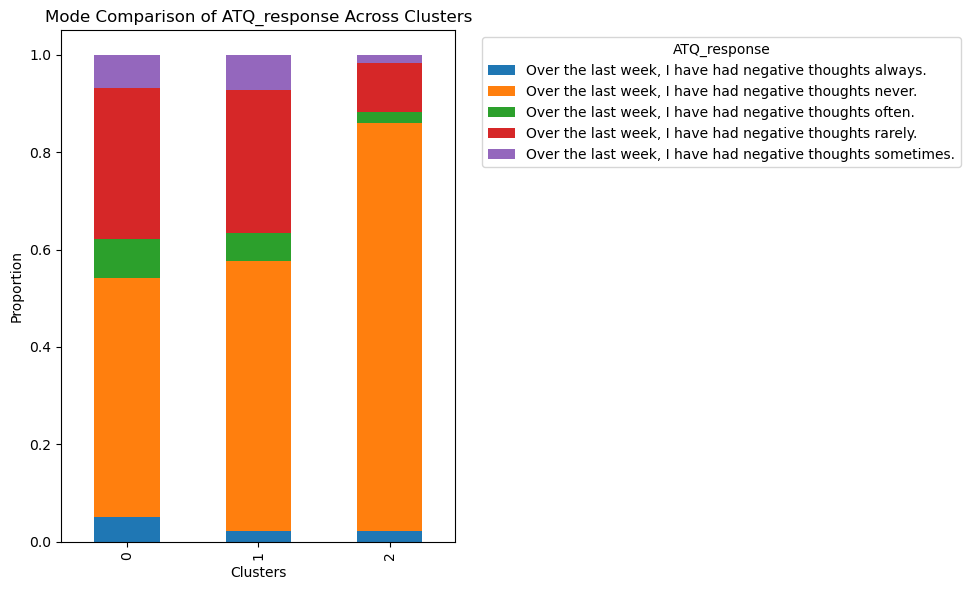

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


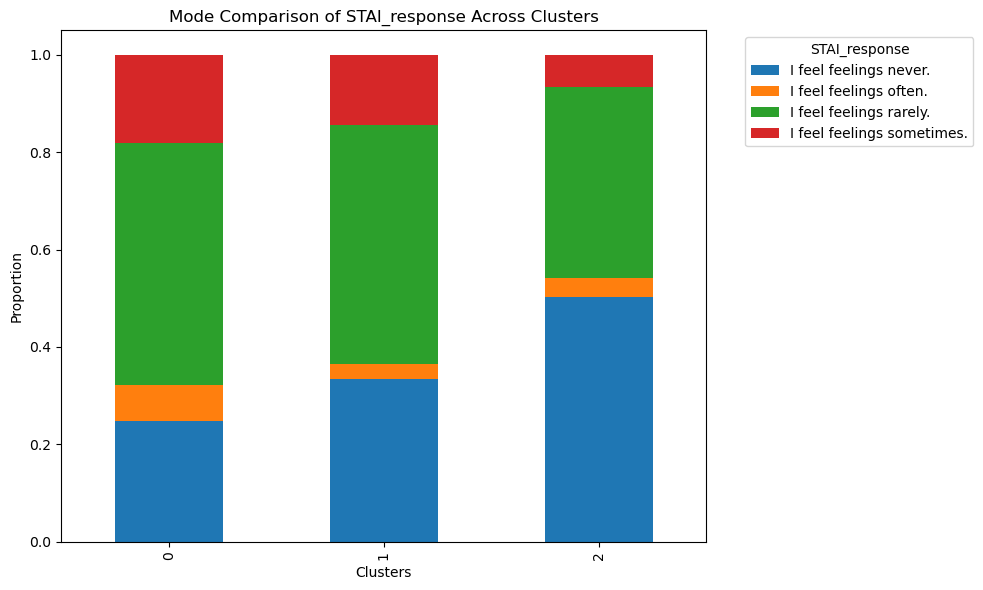

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


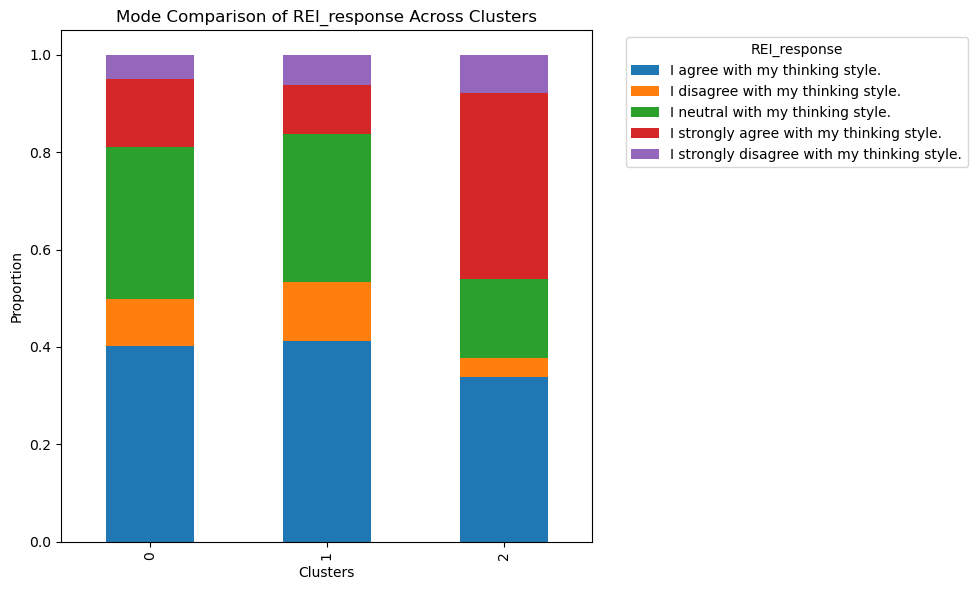

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


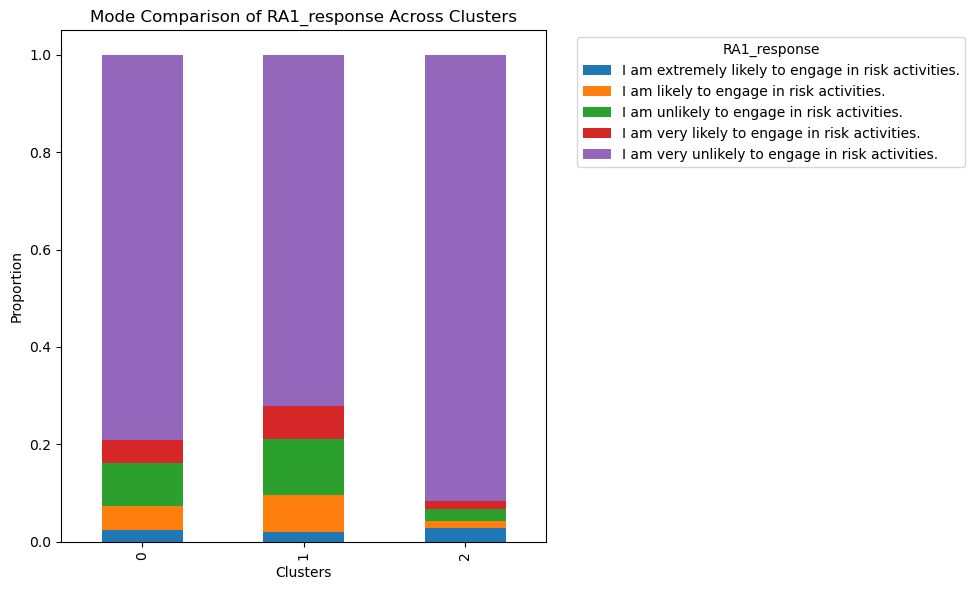

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


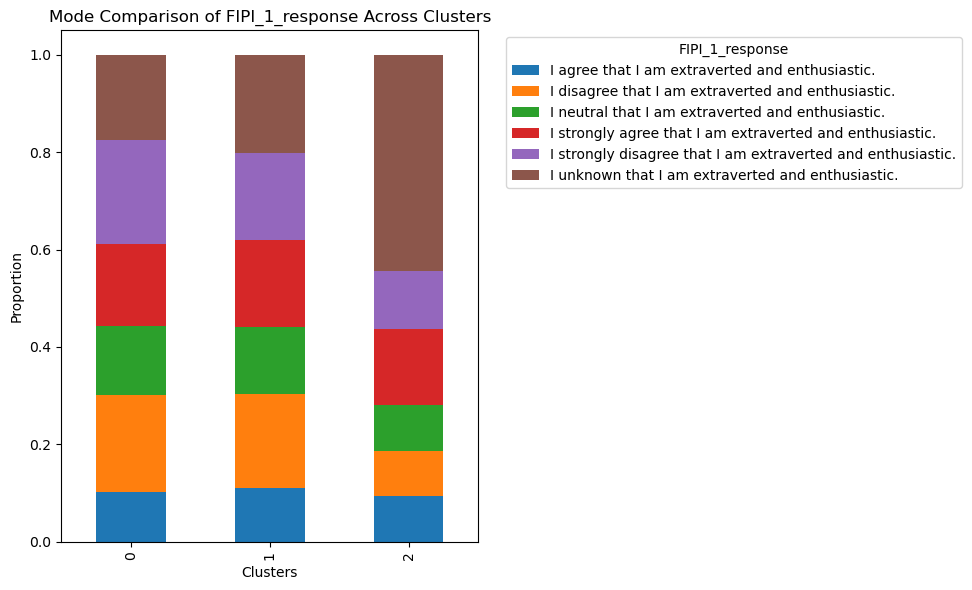

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


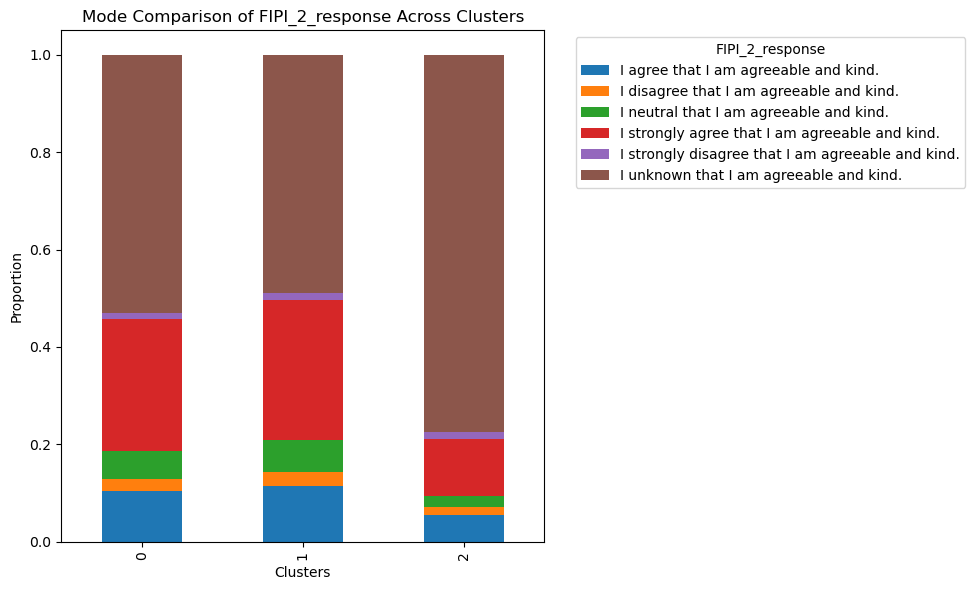

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


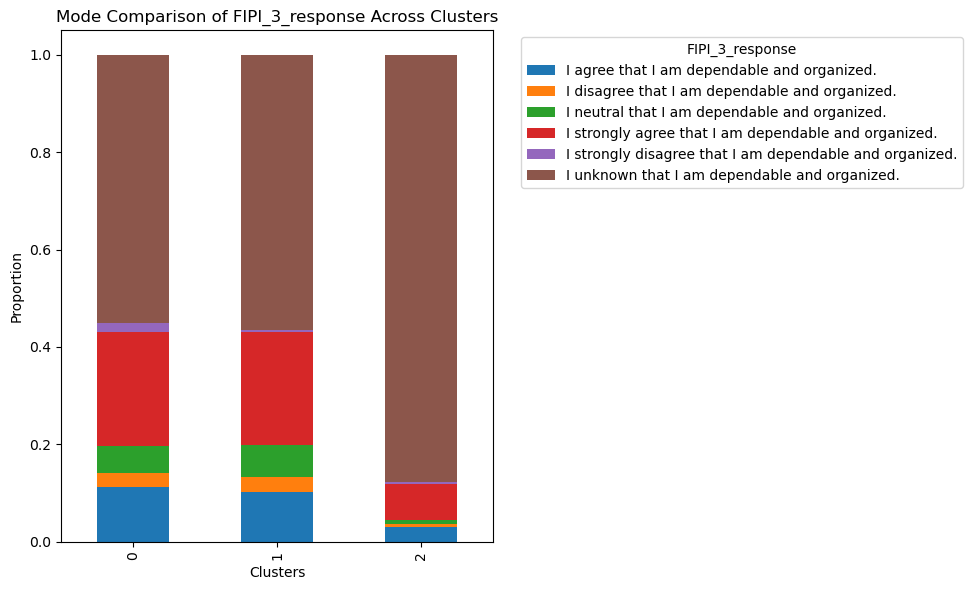

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


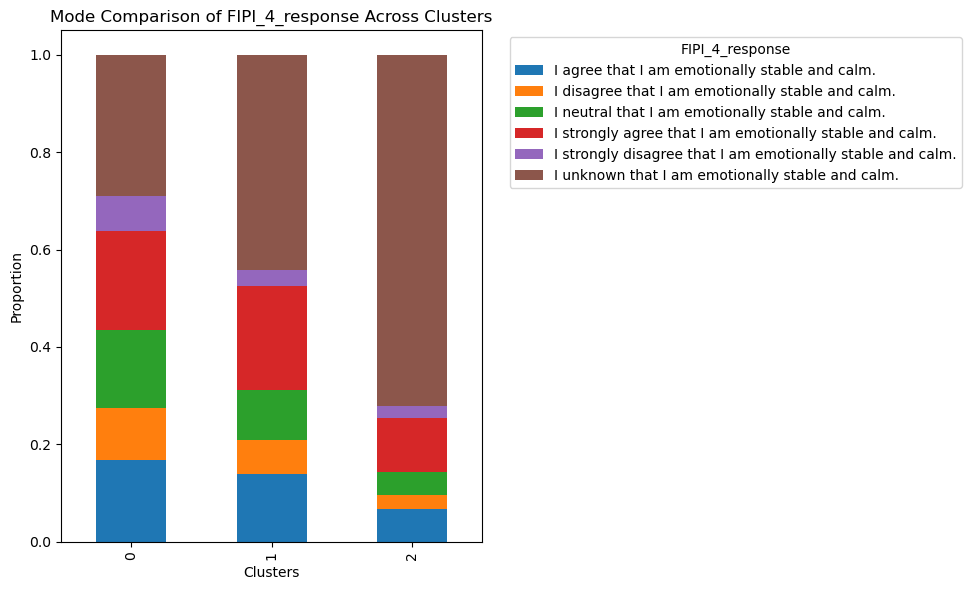

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\609885290.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


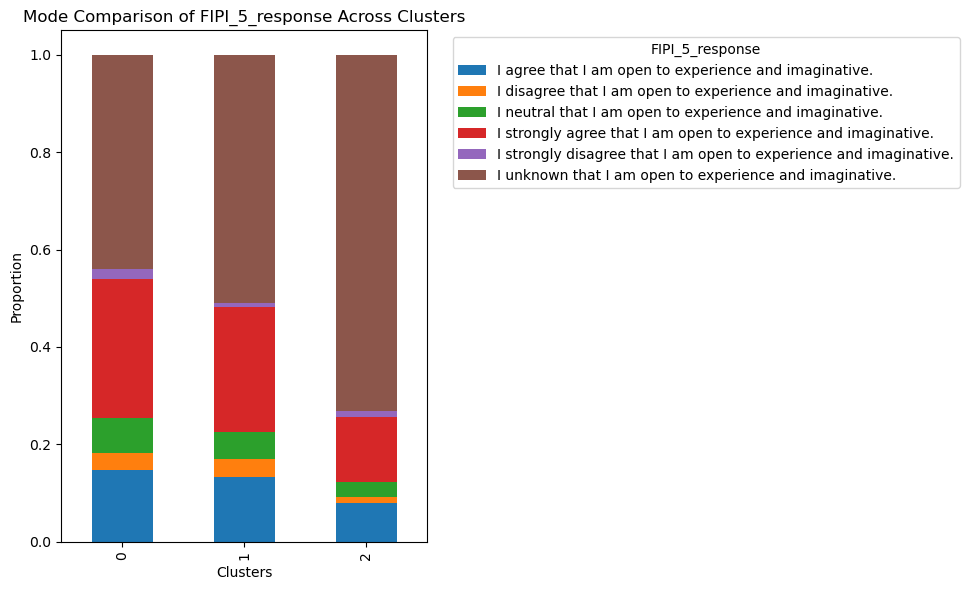

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 定义映射字典
sex_map = {1: 'Male', 2: 'Female'}
race_map = {
    1: 'White', 2: 'Black or African American', 3: 'Asian', 
    4: 'Native American or American Indian', 5: 'Native Hawaiian or Pacific Islander', 
    6: 'Multiracial or biracial', 7: 'Other', 8: 'I choose not to answer'
}
education_map = {
    1: '8th grade or less', 2: 'Attended high school', 3: 'High school graduate',
    4: 'Some college', 5: 'College graduate', 6: 'Some graduate school',
    7: 'Grad / professional degree', 8: 'I choose not to answer'
}
income_map = {
    1: 'Less than $20,000', 2: '$20,000 - $34,999', 3: '$35,000 - $54,999',
    4: '$55,000 - $74,999', 5: '$75,000 - $89,999', 6: '$90,000 or more',
    7: 'Do not know / not sure', 8: 'I choose not to answer'
}
english_first_language_map = {0: 'No', 1: 'Yes'}



# 创建原数据的副本
mapped_data = train_data.copy()

# 应用映射到副本数据
mapped_data['D2'] = mapped_data['D2'].map(sex_map)
mapped_data['D3'] = mapped_data['D3'].map(race_map)
mapped_data['D4'] = mapped_data['D4'].map(education_map)
mapped_data['D5'] = mapped_data['D5'].map(income_map)
mapped_data['D6'] = mapped_data['D6'].map(english_first_language_map)

# 提取特征和群集标签
demographic_features = mapped_data.columns.tolist()
clusters = mapped_data['clusters']

# 计算每个群集中类别特征的众数（模式）
categorical_centroids = mapped_data.groupby(clusters).agg(lambda x: x.mode()[0])

# 显示众数表
print(categorical_centroids)

# 可视化每个类别特征在不同群集中的众数比例
for feature in demographic_features:
    if feature == 'clusters':
        continue
    mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)
    mode_counts = mode_counts.div(mode_counts.sum(axis=1), axis=0)  # 归一化以进行百分比比较

    mode_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Mode Comparison of {feature} Across Clusters')
    plt.xlabel('Clusters')
    plt.ylabel('Proportion')
    plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances_argmin_min

# 假设 reduced_data 是UMAP降维后的数据，original_data 是原始数据
# kmeans 是已经在降维数据上训练好的 KMeans 模型
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, reduced_data)

# 假设 original_data 是一个 DataFrame，包含聚类之前的全部原始数据
original_centroids = train_data.iloc[closest]

original_centroids['D2'] = original_centroids['D2'].map(sex_map)
original_centroids['D3'] = original_centroids['D3'].map(race_map)
original_centroids['D4'] = original_centroids['D4'].map(education_map)
original_centroids['D5'] = original_centroids['D5'].map(income_map)
original_centroids['D6'] = original_centroids['D6'].map(english_first_language_map)

print("Original data points closest to centroids:")
print(original_centroids)


Original data points closest to centroids:
         D1      D2                         D3                    D4  \
1047  50-59  Female                      Asian      College graduate   
5694  30-39    Male                      White          Some college   
6373  40-49  Female  Black or African American  High school graduate   

                     D5   D6 Dmed_7       Dmed_8       DMed_1 DMed_2  ...  \
1047  Less than $20,000  Yes      1  125-150 lbs  More than 3    Yes  ...   
5694  $20,000 - $34,999  Yes      2  150-175 lbs          2-3    Yes  ...   
6373  $55,000 - $74,999  Yes      1  175-200 lbs    1 or less    Yes  ...   

                                           ATQ_response  \
1047  Over the last week, I have had negative though...   
5694  Over the last week, I have had negative though...   
6373  Over the last week, I have had negative though...   

                STAI_response                                 REI_response  \
1047   I feel feelings never.  I strongly di

C:\Users\howar\AppData\Local\Temp\ipykernel_16440\1572016023.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_centroids['D2'] = original_centroids['D2'].map(sex_map)
C:\Users\howar\AppData\Local\Temp\ipykernel_16440\1572016023.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_centroids['D3'] = original_centroids['D3'].map(race_map)
C:\Users\howar\AppData\Local\Temp\ipykernel_16440\1572016023.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

## 2. Pretrain GPT Model

### GPT4

In [20]:
# 假设 data 是你的Pandas DataFrame
output_dir_train = 'Data\clusters\demographic_behavioral_psychological/train'
output_dir_test = 'Data\clusters\demographic_behavioral_psychological/test'

if not os.path.exists(output_dir_train):
    os.makedirs(output_dir_train)

if not os.path.exists(output_dir_test):
    os.makedirs(output_dir_test)

In [21]:
#condition?
def convert_to_prompt_demo(row):
    # Age
    age = f"{row['D1']} years old" if not pd.isna(row['D1']) else "unknown age"
    
    # Sex
    sex = "male" if row['D2'] == 1 else "female" if row['D2'] == 2 else "unknown sex"
    
    # Race
    race_options = [
        "White", "Black or African American", "Asian", 
        "Native American or American Indian", "Native Hawaiian or Pacific Islander", 
        "Multiracial or biracial", "Other", "Prefer not to say"
    ]
    race = race_options[int(row['D3']) - 1] if not pd.isna(row['D3']) else "unknown race"
    
    # Education
    education_options = [
        "8th grade or less", "some high school education", "high school graduate", 
        "some college education", "college graduate", "some graduate school education", 
        "a graduate or professional degree", "prefer not to say"
    ]
    education = education_options[int(row['D4']) - 1] if not pd.isna(row['D4']) else "unknown educational background"
    
    # Income
    income_options = [
        "less than $20,000", "$20,000 - $34,999", "$35,000 - $54,999", 
        "$55,000 - $74,999", "$75,000 - $89,999", "$90,000 or more", 
        "unknown income", "prefer not to say"
    ]
    income = income_options[int(row['D5']) - 1] if not pd.isna(row['D5']) else "unknown income"
    
    # Language
    english_first_lang = "English is your first language" if row['D6'] == 1 else \
                         "English is not your first language" if row['D6'] == 2 else \
                         "it is unknown if English is your first language"
    
    # Physical measurements
    height = f"{row['Dmed_7']} feet tall" if not pd.isna(row['Dmed_7']) else "unknown height"
    weight = f"weighs {row['Dmed_8']} pounds" if not pd.isna(row['Dmed_8']) else "unknown weight"
    
    # Combine all into one prompt
    prompt = (
        f"You are {age}, {sex}, of {race} descent. You have {education} and an annual income of {income}. "
        f"{english_first_lang}. You are {height} and {weight}."
    )
    
    return prompt


def convert_to_prompt_behavioral(row):
    intro = "You are someone who "

    # 根据药物数量
    if row['DMed_1'] == '1 or less':
        intro += "takes few or no prescription drugs regularly, "
    elif row['DMed_1'] == '2-3':
        intro += "takes a moderate number of prescription drugs regularly, "
    else:
        intro += "takes many prescription drugs regularly, "

    # 根据是否有主要护理医师
    if row['DMed_2'] == 'Yes':
        intro += "has a primary care physician, "
    else:
        intro += "does not have a primary care physician, "

    # 根据访问医师的频率
    if row['DMed_3'] == '0-2 times':
        intro += "and rarely visits them. "
    elif row['DMed_3'] == '3-5 times':
        intro += "and occasionally visits them. "
    else:
        intro += "and frequently visits them. "

    # 根据运动小时数
    if row['DMed_9'] == '0-2 hours':
        intro += "You engage in little physical activity weekly. "
    elif row['DMed_9'] == '3-5 hours':
        intro += "You have a moderate weekly physical activity. "
    elif row['DMed_9'] == '6-10 hours':
        intro += "You are quite active physically on a weekly basis. "
    else:
        intro += "You are very active, engaging in many hours of physical activity every week. "

    # 结合健康意识
    if row['HC_1'] == 'Agree':
        intro += "Living in the best possible health is very important to you. "

    return intro

def convert_to_prompt_psychological(row):
    intro = "You are someone who "

    # 添加 REI_response
    intro += row['REI_response'] + " "

    # 添加 RA1_response
    intro += row['RA1_response'] + " "

    # 添加 STAI_response
    intro += row['STAI_response'] + " "

    # 添加 BSCS_response
    intro += row['BSCS_response'] + " "

    # 添加 ATQ_response
    intro += row['ATQ_response'] + " "

    # 添加 TWB_response
    intro += row['TWB_response'] + " "

    # 添加 FIPI 各个部分的 response
    intro += row['FIPI_1_response'] + " "
    intro += row['FIPI_2_response'] + " "
    intro += row['FIPI_3_response'] + " "
    intro += row['FIPI_4_response'] + " "
    intro += row['FIPI_5_response'] + " "

    return intro.strip()


In [22]:

# 分割数据集为7个子数据集并进行训练/测试分割
clustered_datasets = {}
train_datasets = {}
test_datasets = {}

for i in range(best_k):  
    cluster_data = data[data['clusters'] == i].head(100)
    train, test = train_test_split(cluster_data, test_size=0.2, random_state=42)  # 20% 数据作为测试集
    train_datasets[f'Cluster_{i}'] = train
    test_datasets[f'Cluster_{i}'] = test


def convert_to_jsonl_format(clustered_datasets, output_dir):
    for cluster, dataset in clustered_datasets.items():
        # Fill missing values
        
        jsonl_data = []
        for index, row in dataset.iterrows():
            system_prompt = "You should simulate a specified person's persona based on the background information I provided. You are currently visiting a psychologist." + convert_to_prompt_demo(row) + convert_to_prompt_behavioral(row) + convert_to_prompt_psychological(row)
            # Combining the responses into the completion field
            jsonl_data.append({
                "messages": [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": Text_SubjectiveLit},
                    {"role": "assistant", "content": row['Text_SubjectiveLit']},
                    {"role": "user", "content": Text_TrustPhys},
                    {"role": "assistant", "content": row['Text_TrustPhys']},
                    {"role": "user", "content": Text_Anxiety},
                    {"role": "assistant", "content": row['Text_Anxiety']},
                    {"role": "user", "content": Text_Numeracy},
                    {"role": "assistant", "content": row['Text_Numeracy']}
                ]
                })
                
        # Saving the jsonl files
        filename = os.path.join(output_dir, f"{cluster}.jsonl")
        with open(filename, 'w') as f:
            for entry in jsonl_data:
                f.write(json.dumps(entry) + "\n")
        print(f"Saved {filename}")


# 转换训练数据和测试数据为JSON格式并保存
convert_to_jsonl_format(train_datasets, output_dir_train)
convert_to_jsonl_format(test_datasets, output_dir_test)


Saved Data\clusters\demographic_behavioral_psychological/train\Cluster_0.jsonl
Saved Data\clusters\demographic_behavioral_psychological/train\Cluster_1.jsonl
Saved Data\clusters\demographic_behavioral_psychological/train\Cluster_2.jsonl
Saved Data\clusters\demographic_behavioral_psychological/test\Cluster_0.jsonl
Saved Data\clusters\demographic_behavioral_psychological/test\Cluster_1.jsonl
Saved Data\clusters\demographic_behavioral_psychological/test\Cluster_2.jsonl


In [23]:
#modify
data_path = "Data\clusters\demographic_and_behavioral/train\Cluster_1.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 80
First example:
{'role': 'system', 'content': "You should simulate a specified person's persona based on the background information I provided. You are currently visiting a psychologist.You are 60 and above years old, male, of White descent. You have some graduate school education and an annual income of $90,000 or more. English is your first language. You are 2 feet tall and weighs 175-200 lbs pounds.You are someone who takes a moderate number of prescription drugs regularly, has a primary care physician, and frequently visits them. You have a moderate weekly physical activity. Living in the best possible health is very important to you. You are someone who I neutral with my thinking style. I am very unlikely to engage in risk activities. I feel feelings sometimes. I neutral that my self-control is strong. Over the last week, I have had negative thoughts never. I disagree that my well-being is good. I strongly disagree that I am extraverted and enthusiastic. I neutral 

In [24]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


## 4. Testing results

In [3]:
models = ["ft:gpt-4o-mini-2024-07-18:personal:demo-psych-beha-0:9thgfKwF",
          "ft:gpt-4o-mini-2024-07-18:personal:demo-beha-psych-1:9ths8DSO",
            "ft:gpt-4o-mini-2024-07-18:personal:demo-beha-psych-2:9thsykX7",
            "gpt-3.5-turbo-0125"
            ]

user_prompt = {"Text_Numeracy": Text_Numeracy, 
               "Text_Anxiety": Text_Anxiety, 
               "Text_TrustPhys": Text_TrustPhys, 
               "Text_SubjectiveLit": Text_SubjectiveLit}

In [26]:
from openai import OpenAI
import json
from collections import defaultdict

client = OpenAI()

#response from a single person (i = which model, j = resp from jth question)
def perfromace_across_models(models, system_prompt, user_prompt):
  response_list = defaultdict(lambda: {prompt: [] for prompt in user_prompt})
  for i, model in enumerate(models):
    for j in user_prompt:
      response = client.chat.completions.create(
        model= model,
        messages=[{"role": "system", "content": system_prompt}, 
                  {"role": "user", "content": user_prompt[j]}],
        temperature=1,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
      ).choices[0].message.content
      response_list[i][j].append(response)
  
  return response_list


def dict_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: dict_to_regular(v) for k, v in d.items()}
    return d



In [28]:
# Path to the uploaded file
file_paths = [f'Data\clusters\demographic_behavioral_psychological/test\Cluster_{i}.jsonl' for i in range(best_k)]

# Reading the JSONL file and converting it to a list of dictionaries
datas = []

for file_path in file_paths:
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    datas.append(data)

In [29]:
#j = jth cluster
for j, data in enumerate(datas):
    all_responses = []
    all_labels = []

    for i in range(len(data)):
        labels =  {prompt: "" for prompt in user_prompt}
        system_prompt = data[i]["messages"][0]["content"] #peronal information
        q1 = data[i]["messages"][2]["content"]  #answer for q1
        q2 = data[i]["messages"][4]["content"]
        q3 = data[i]["messages"][6]["content"]
        q4 = data[i]["messages"][8]["content"]

        user_response = perfromace_across_models(models, system_prompt, user_prompt)
        #user_response[i][j] = ith model's jth question's  response 
        labels['Text_Numeracy'] = q1
        labels['Text_Anxiety'] = q2
        labels['Text_TrustPhys'] = q3
        labels['Text_SubjectiveLit'] = q4
        
        all_responses.append(user_response)
        all_labels.append(labels)

    all_responses_output_dir = f"results/cluster_{j}/all_responses_demo_beha_psych.json"
    all_labels_output_dir = f"results/cluster_{j}/all_labels_demo_beha_psych.json"

    os.makedirs(os.path.dirname(all_responses_output_dir), exist_ok=True)
    os.makedirs(os.path.dirname(all_labels_output_dir), exist_ok=True)

    # 将 all_responses 中的 defaultdict 转换为普通字典
    all_responses_regular = [dict_to_regular(d) for d in all_responses]

    # 序列化为 JSON 并保存到文件
    with open(all_responses_output_dir, 'w') as f:
        json.dump(all_responses_regular, f)

    with open(all_labels_output_dir, 'w') as f:
        json.dump(all_labels, f)


## Evaluation methods

In [5]:
all_responses = []
all_labels = []

#all_response[clust][i][j][k] = [nth clust][ith person][jth model][kth question]
#all_labels[clust][i][k] = [nth clust][ith person][kth question]

# 从文件中读取并反序列化 JSON 的函数
def regular_to_defaultdict(d):
    if isinstance(d, dict):
        return defaultdict(lambda: {prompt: [] for prompt in user_prompt},
                           {k: regular_to_defaultdict(v) for k, v in d.items()})
    return d

for i in range(best_k):
    # 从文件中读取 JSON 数据并转换回 defaultdict
    with open(f'results/cluster_{i}/all_responses_demo_beha_psych.json', 'r') as f:
        all_responses_loaded = json.load(f)

    with open(f'results/cluster_{i}/all_labels_demo_beha_psych.json', 'r') as f:
        all_labels_loaded = json.load(f)

    all_responses.append([regular_to_defaultdict(d) for d in all_responses_loaded])
    all_labels.append([d for d in all_labels_loaded])

### 1. Text Similarity

In [6]:
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(paragraph1, paragraph2):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Tokenize and prepare the inputs
    inputs1 = tokenizer(paragraph1, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs2 = tokenizer(paragraph2, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Encode the paragraphs using the BERT model
    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)

    # Use mean pooling to get sentence embeddings
    embeddings1 = outputs1.last_hidden_state.mean(dim=1).numpy()
    embeddings2 = outputs2.last_hidden_state.mean(dim=1).numpy()

    # Calculate cosine similarity
    similarity = cosine_similarity(embeddings1, embeddings2)
    return similarity


all_similarities_cosine = {f"cluster_{j}" : [] for j in range(best_k)}

for clust in range(len(all_labels)):
    similarities = []
    for i, person in enumerate(all_labels[clust]):
        label = [person["Text_Numeracy"], person["Text_Anxiety"], person["Text_TrustPhys"], person["Text_SubjectiveLit"]]
        
        answer_models = [
            [all_responses[clust][i][str(model_idx)]["Text_Numeracy"],
             all_responses[clust][i][str(model_idx)]["Text_Anxiety"],
             all_responses[clust][i][str(model_idx)]["Text_TrustPhys"],
             all_responses[clust][i][str(model_idx)]["Text_SubjectiveLit"]]
            for model_idx in range(len(models))
        ]

        scores = [[] for _ in range(len(models))]  # 存放5个模型的分数

        for j in range(len(label)):
            for model_idx in range(len(models)):
                scores[model_idx].append(calculate_similarity(label[j], answer_models[model_idx][j]))

        similarities.append(scores)  # 包含所有模型的分数
    all_similarities_cosine[f"cluster_{clust}"] = similarities

In [7]:
all_responses

[[defaultdict(<function __main__.regular_to_defaultdict.<locals>.<lambda>()>,
              {'0': defaultdict(<function __main__.regular_to_defaultdict.<locals>.<lambda>()>,
                           {'Text_Numeracy': ["I don't have any such experiences"],
                            'Text_Anxiety': ["I get court anxiety when visiting a doctors office. It doesn't matter what kind of doctor I am seeing and it is even worse when I am seeing a doctor I have never seen before. to anxiety when visiting a doctors office"],
                            'Text_TrustPhys': ["I have been seeing the same doctor for a couple of years now. When I first met with her, I shared all of my medical history with her even though I had records from previous doctors. She asked me if I had any records with me. I told her that they were at home and I would bring them next time. She made it very clear that my medical history is not her business and she does not want to know anything about me that she can not fin

In [ ]:
''' 
structure of all_similarities_cosine
{
    "cluster_0": [
        # Person 0 in cluster_0
        [
            [similarity_Numeracy_model0, similarity_Anxiety_model0, similarity_TrustPhys_model0, similarity_SubjectiveLit_model0],  # model 0 scores
            [similarity_Numeracy_model1, similarity_Anxiety_model1, similarity_TrustPhys_model1, similarity_SubjectiveLit_model1],  # model 1 scores
            [similarity_Numeracy_model2, similarity_Anxiety_model2, similarity_TrustPhys_model2, similarity_SubjectiveLit_model2],  # model 2 scores
            [similarity_Numeracy_model3, similarity_Anxiety_model3, similarity_TrustPhys_model3, similarity_SubjectiveLit_model3],  # model 3 scores
            [similarity_Numeracy_regular, similarity_Anxiety_regular, similarity_TrustPhys_regular, similarity_SubjectiveLit_regular]  # regular model scores
        ],
        # Person 1 in cluster_0
        [
            [similarity_Numeracy_model0, similarity_Anxiety_model0, similarity_TrustPhys_model0, similarity_SubjectiveLit_model0],
            [similarity_Numeracy_model1, similarity_Anxiety_model1, similarity_TrustPhys_model1, similarity_SubjectiveLit_model1],
            [similarity_Numeracy_model2, similarity_Anxiety_model2, similarity_TrustPhys_model2, similarity_SubjectiveLit_model2],
            [similarity_Numeracy_model3, similarity_Anxiety_model3, similarity_TrustPhys_model3, similarity_SubjectiveLit_model3],
            [similarity_Numeracy_regular, similarity_Anxiety_regular, similarity_TrustPhys_regular, similarity_SubjectiveLit_regular]
        ],
        # More people in cluster_0
    ],
    "cluster_1": [
        # Similar structure as cluster_0
    ],
    # More clusters
}

'''

In [9]:
all_similarities_cosine

{'cluster_0': [[[array([[0.5756127]], dtype=float32),
    array([[0.8028482]], dtype=float32),
    array([[0.85884833]], dtype=float32),
    array([[0.7524054]], dtype=float32)],
   [array([[0.71581244]], dtype=float32),
    array([[0.76282656]], dtype=float32),
    array([[0.8155571]], dtype=float32),
    array([[0.7963451]], dtype=float32)],
   [array([[0.675336]], dtype=float32),
    array([[0.72488445]], dtype=float32),
    array([[0.8040485]], dtype=float32),
    array([[0.72827095]], dtype=float32)],
   [array([[0.84364724]], dtype=float32),
    array([[0.7195814]], dtype=float32),
    array([[0.7898269]], dtype=float32),
    array([[0.7446418]], dtype=float32)]],
  [[array([[0.83741343]], dtype=float32),
    array([[0.76911646]], dtype=float32),
    array([[0.7170369]], dtype=float32),
    array([[0.7535981]], dtype=float32)],
   [array([[0.72238284]], dtype=float32),
    array([[0.73267955]], dtype=float32),
    array([[0.77675056]], dtype=float32),
    array([[0.7490585]], dty

In [10]:
import numpy as np

# Initialize dictionary to store the average scores
average_scores = {}

# Loop over each cluster
for cluster_name, people in all_similarities_cosine.items():
    model_index = int(cluster_name.split('_')[1])  # Extract the model index from the cluster name
    scores = [person[model_index] for person in people]  # Extract scores for the corresponding model
    average_scores[cluster_name] = np.mean(scores, axis=0)  # Calculate the mean for the model

average_scores


{'cluster_0': array([[[0.74086946]],
 
        [[0.7588472 ]],
 
        [[0.7681404 ]],
 
        [[0.7482043 ]]], dtype=float32),
 'cluster_1': array([[[0.7378599 ]],
 
        [[0.7540787 ]],
 
        [[0.75049496]],
 
        [[0.74183244]]], dtype=float32),
 'cluster_2': array([[[0.77036464]],
 
        [[0.7505177 ]],
 
        [[0.7265092 ]],
 
        [[0.7256018 ]]], dtype=float32)}

In [8]:

# Calculate average similarities for each model in each cluster
best_models = {}

for clust, sim_list in all_similarities_cosine.items():
    cluster_similarities = np.array(sim_list)
    average_model_similarities = np.mean(cluster_similarities, axis=(0, 1))  # Axis 0 is people, axis 1 is fields

    best_model_idx = np.argmax(average_model_similarities)
    best_models[clust] = best_model_idx

    print(f"Cluster {clust}, Best model: model{best_model_idx} with average similarity: {average_model_similarities[best_model_idx]}")

# Print the best models for all clusters
print("Best models for all clusters:", best_models)

Cluster cluster_0, Best model: model1 with average similarity: [[0.7591558]]
Cluster cluster_1, Best model: model0 with average similarity: [[0.75219774]]
Cluster cluster_2, Best model: model0 with average similarity: [[0.76908004]]
Best models for all clusters: {'cluster_0': 1, 'cluster_1': 0, 'cluster_2': 0}


### 2. LLM as judge? comparing responses between label & different models

Dimensions：
1. similarity on decision
2. similarity on personality
3. hallucination
4. stability


In [7]:
judger = OpenAI()
system_judger_prompt = "You are a professional psychologist with extensive experience in evaluating textual responses for various psychological and cognitive dimensions. "

def get_response(judger, message):
    response = judger.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_judger_prompt},
            {"role": "user", "content": message}
        ]
    )
    return response.choices[0].message.content

def extract_numeric_score(response_text):
    match = re.search(r"(\d+(\.\d+)?)", response_text)
    if match:
        return float(match.group(1))
    else:
        return 0.0
    
def calculate_similarity_llm(label, answer):
    dimensions = ["similarity on decision", "similarity on personality", "hallucination", "stability"]
    scores = []
    for dimension in dimensions:
        message = f"Evaluate the following model response based on the dimension of '{dimension}' comparing to the label response:\n\nLabel response: {label}\nModel response: {answer}\n\nScore (1-10). Please only output the number."
        score_text = get_response(judger, message)
        score = extract_numeric_score(score_text)
        scores.append(score)
    return sum(scores) / len(scores)

In [11]:
all_similarities = {f"cluster_{j}" : [] for j in range(best_k)}

for clust in range(len(all_labels)):
    similarities = []
    for i, person in enumerate(all_labels[clust]):
        label = [person["Text_Numeracy"], person["Text_Anxiety"], person["Text_TrustPhys"], person["Text_SubjectiveLit"]]
        
        answer_models = [
            [all_responses[clust][i][str(model_idx)]["Text_Numeracy"],
             all_responses[clust][i][str(model_idx)]["Text_Anxiety"],
             all_responses[clust][i][str(model_idx)]["Text_TrustPhys"],
             all_responses[clust][i][str(model_idx)]["Text_SubjectiveLit"]]
            for model_idx in range(5)
        ]

        scores = [[] for _ in range(5)]  # 存放5个模型的分数

        for j in range(len(label)):
            for model_idx in range(5):
                scores[model_idx].append(calculate_similarity_llm(label[j], answer_models[model_idx][j]))

        similarities.append(scores)  # 包含所有模型的分数
    all_similarities[f"cluster_{clust}"] = similarities


In [12]:
import numpy as np

best_models = {}
all_scores = {}

for clust, sim_list in all_similarities.items():
    cluster_similarities = np.array(sim_list)
    
    # Calculate the mean similarity for each model across all fields for each person
    mean_similarities_per_person = np.mean(cluster_similarities, axis=2)
    
    # Calculate the average similarity for each model across all people
    average_model_similarities = np.mean(mean_similarities_per_person, axis=0)
    
    best_model_idx = np.argmax(average_model_similarities)
    best_models[clust] = best_model_idx
    all_scores[clust] = average_model_similarities

    print(f"Cluster {clust}, Model scores: {average_model_similarities}")
    print(f"Cluster {clust}, Best model: model{best_model_idx} with average similarity: {average_model_similarities[best_model_idx]}")

# Print the best models for all clusters
print("Best models for all clusters:", best_models)


Cluster cluster_0, Model scores: [2.6625  2.725   2.7375  3.35    3.49375]
Cluster cluster_0, Best model: model4 with average similarity: 3.49375
Cluster cluster_1, Model scores: [2.425    2.771875 2.728125 3.378125 3.84375 ]
Cluster cluster_1, Best model: model4 with average similarity: 3.84375
Cluster cluster_2, Model scores: [2.7421875 2.7625    2.5765625 3.4375    3.75     ]
Cluster cluster_2, Best model: model4 with average similarity: 3.75
Best models for all clusters: {'cluster_0': 4, 'cluster_1': 4, 'cluster_2': 4}
